In [1]:
import pandas as pd

data = pd.read_parquet("Download/engine_metadata_combined.parquet")

for col in data.columns:
    print(data[col].value_counts())

filename
--330hg-Ocw_30_40.wav    1
22PsS-3gmUo_30_40.wav    1
1zqDK1IeJZE_30_40.wav    1
2-Ji_FViZBg_28_38.wav    1
2-jQTrNH7PU_14_24.wav    1
                        ..
0XBCbmwTXVc_10_20.wav    1
0XVLMlGFhJ4_30_40.wav    1
0Xl7TgYUVV0_30_40.wav    1
0YI4Kzdi4V4_22_32.wav    1
4uvzX9zT1sM_16_26.wav    1
Name: count, Length: 938, dtype: int64
title
Engine 2 Responding                                               2
C&M Racing Engine                                                 2
Engine                                                            2
Steam Engine                                                      2
Peugeot 306 1.9L Diesel L-Reg Engine Cold Start No Plugs          1
                                                                 ..
65 ford E85 400M  cam break in                                    1
thunderbird supercoupe new engine start.                          1
Ford F-150 Engine Locks up (Cash for Clunkers)                    1
FIAT Stilo 3.0 V6 engine - test run  

Processing audio: 100%|██████████| 915/915 [00:15<00:00, 59.33it/s]


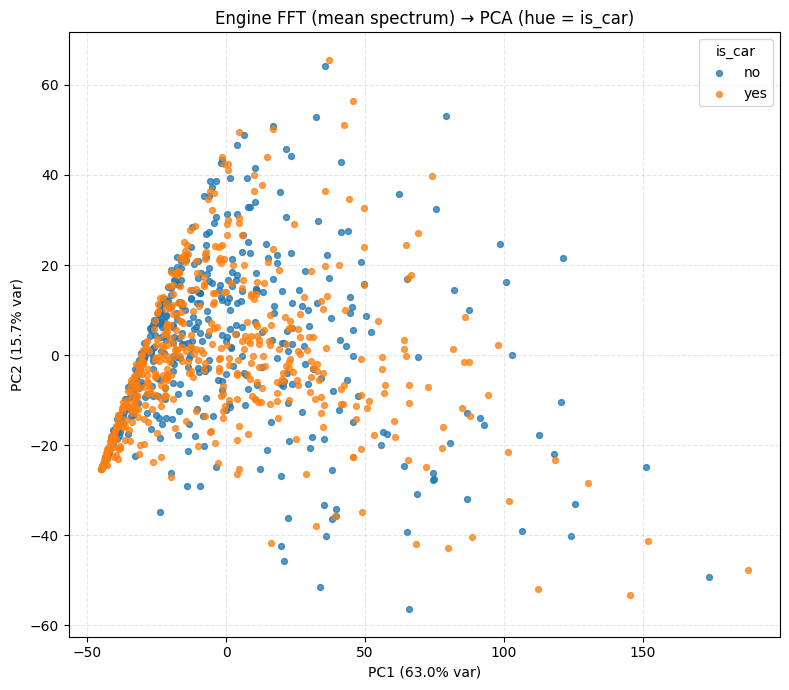

Processed: 914 clips | Missing files: 0 | Failed to parse: 1


In [6]:
# ---- requirements (install if needed) ----
# pip install pandas numpy librosa scikit-learn matplotlib tqdm pyarrow

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# ----------------- config -----------------
PARQUET_PATH = "download/engine_metadata_combined.parquet"   # your file
ENGINE_DIR_PRIMARY = "Download/engine_downloads"              # as you wrote it
ENGINE_DIR_FALLBACK = "download/download_engine"             # fallback in case of case mismatch

TARGET_SR = 22050       # resample for consistency
N_FFT = 4096            # FFT size for STFT (feature length = N_FFT//2 + 1)
HOP_LENGTH = N_FFT // 4 # 75% overlap
RANDOM_STATE = 42

# ----------------- helpers ----------------
def resolve_audio_path(fname: str) -> str | None:
    """Return an existing path for the audio file, or None if not found."""
    p1 = os.path.join(ENGINE_DIR_PRIMARY, fname)
    if os.path.exists(p1):
        return p1
    p2 = os.path.join(ENGINE_DIR_FALLBACK, fname)
    if os.path.exists(p2):
        return p2
    return None

def mean_fft_spectrum(path: str) -> np.ndarray:
    """
    Load audio (mono), resample to TARGET_SR, compute STFT with N_FFT,
    take magnitude^2 (power), average over time, log-compress.
    Returns shape (N_FFT//2 + 1,)
    """
    y, sr = librosa.load(path, sr=TARGET_SR, mono=True)
    if y.size == 0:
        raise ValueError("Empty audio after load.")
    S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH, window="hann"))**2
    spec = S.mean(axis=1)                 # average over time frames
    spec = np.log1p(spec)                 # log compression for stability
    return spec.astype(np.float32)

# --------------- main routine ------------
def main():
    # Load metadata
    df = pd.read_parquet(PARQUET_PATH)
    # Basic cleaning on is_car
    df["is_car"] = df["is_car"].astype(str).str.strip().str.lower()
    df = df[df["is_car"].isin(["yes", "no"])].copy()

    features = []
    labels = []
    used_filenames = []
    missing = 0
    failed = 0

    # Compute features
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing audio"):
        fname = str(row["filename"])
        apath = resolve_audio_path(fname)
        if apath is None:
            missing += 1
            continue
        try:
            feat = mean_fft_spectrum(apath)  # shape (N_FFT//2 + 1,)
            features.append(feat)
            labels.append(row["is_car"])
            used_filenames.append(fname)
        except Exception as e:
            failed += 1

    if len(features) == 0:
        raise RuntimeError("No features extracted. Check paths and file availability.")

    X = np.vstack(features)  # (n_samples, n_features)

    # Scale + PCA to 2D
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xs = scaler.fit_transform(X)

    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca.fit_transform(Xs)

    # Prepare dataframe for plotting
    plot_df = pd.DataFrame({
        "PC1": X2[:, 0],
        "PC2": X2[:, 1],
        "is_car": labels,
        "filename": used_filenames,
    })

    # Scatter plot by hue = is_car
    fig, ax = plt.subplots(figsize=(8, 7))
    for label, grp in plot_df.groupby("is_car"):
        ax.scatter(grp["PC1"], grp["PC2"], s=18, alpha=0.75, label=label)

    evr = pca.explained_variance_ratio_
    ax.set_xlabel(f"PC1 ({evr[0]*100:.1f}% var)")
    ax.set_ylabel(f"PC2 ({evr[1]*100:.1f}% var)")
    ax.set_title("Engine FFT (mean spectrum) → PCA (hue = is_car)")
    ax.legend(title="is_car")
    ax.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Processed: {len(features)} clips | Missing files: {missing} | Failed to parse: {failed}")

if __name__ == "__main__":
    main()


Processing audio: 100%|██████████| 938/938 [00:19<00:00, 47.46it/s]


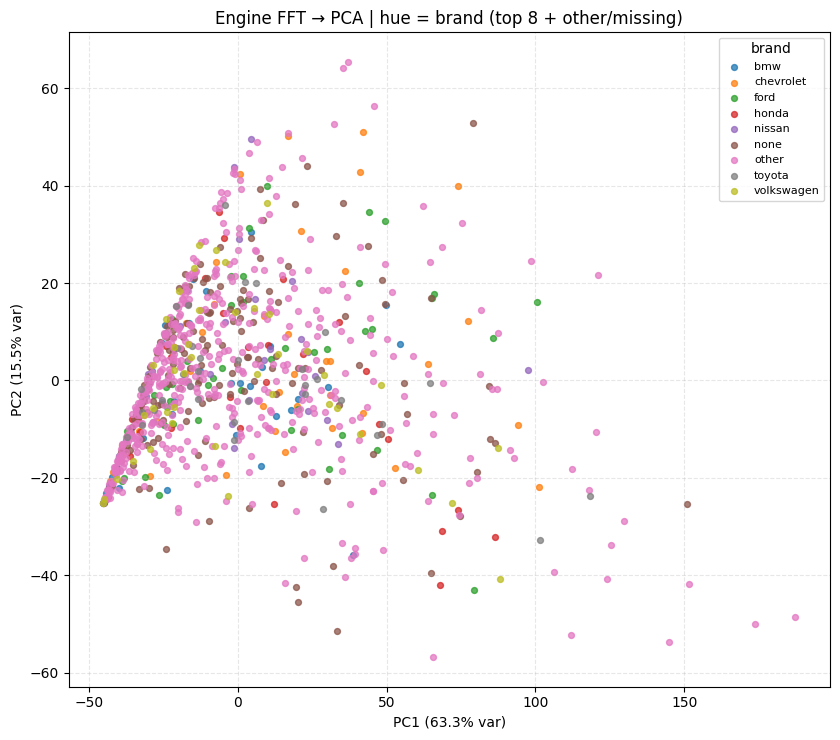

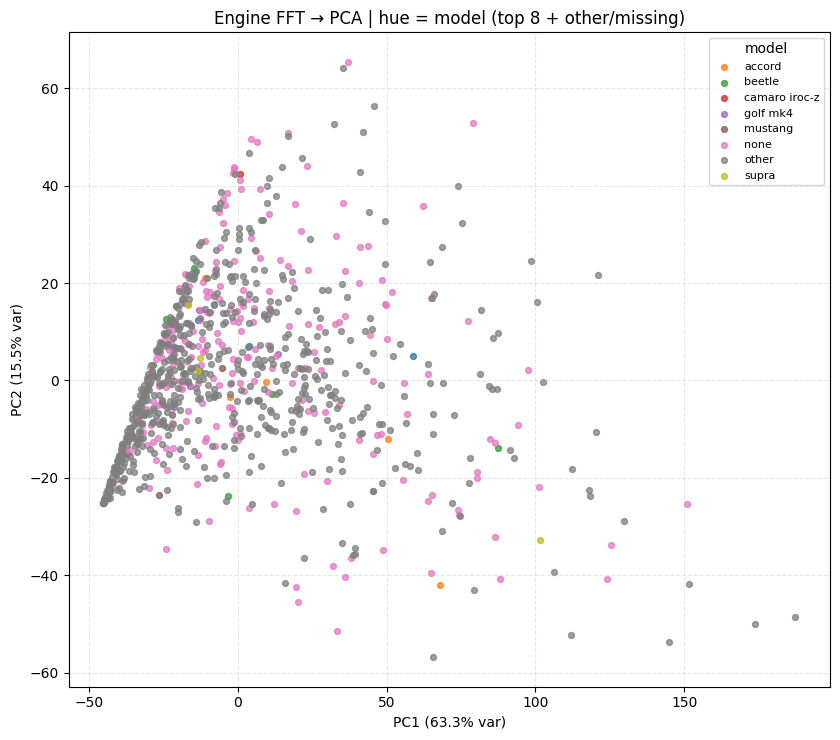

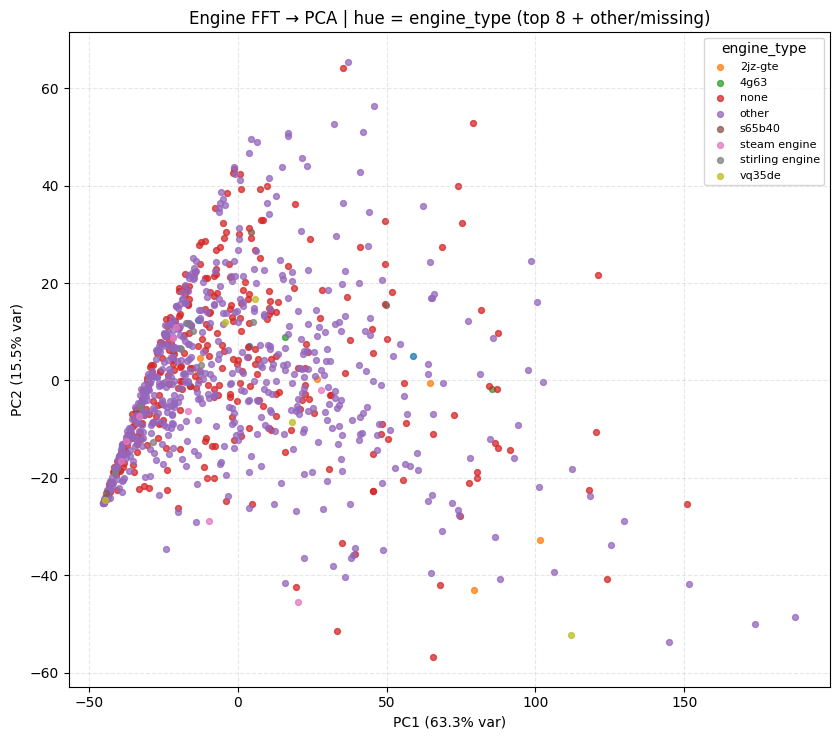

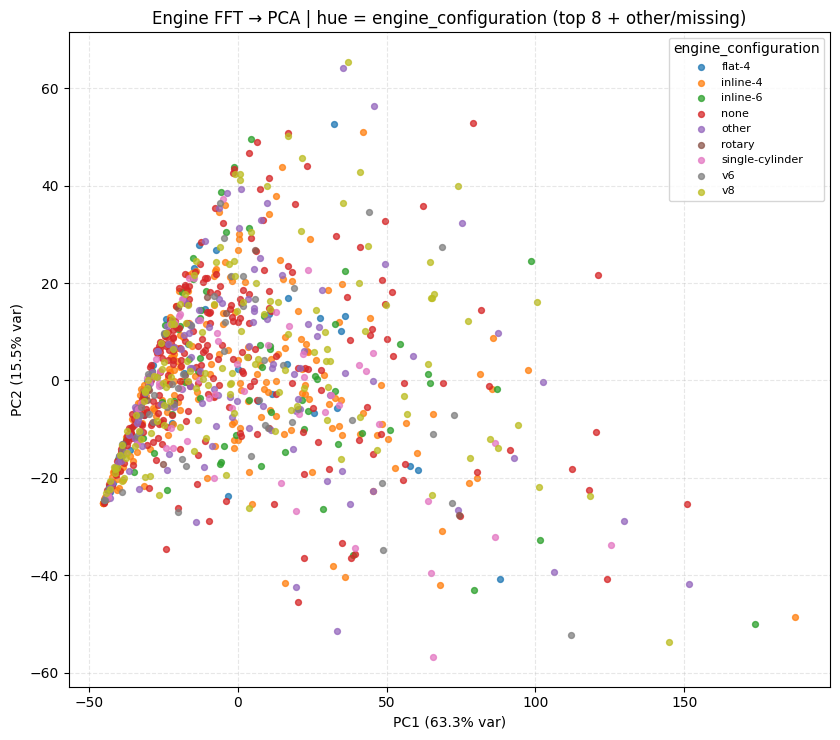

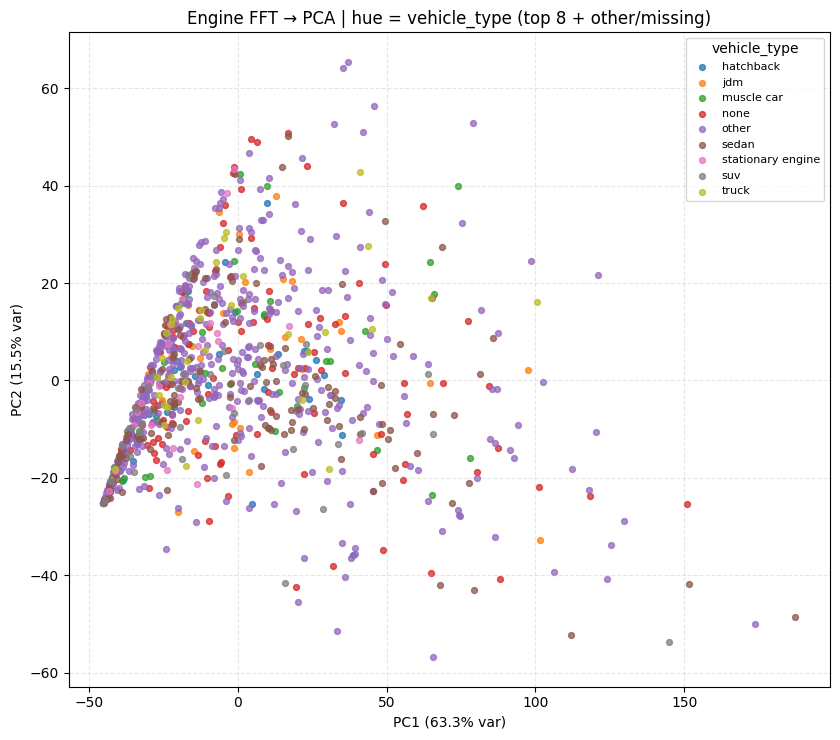

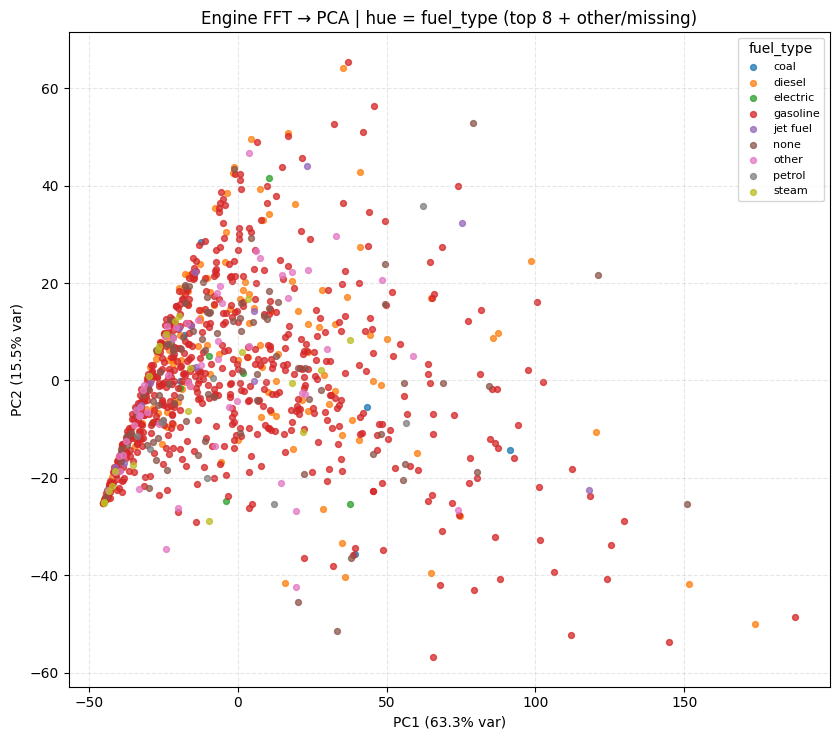

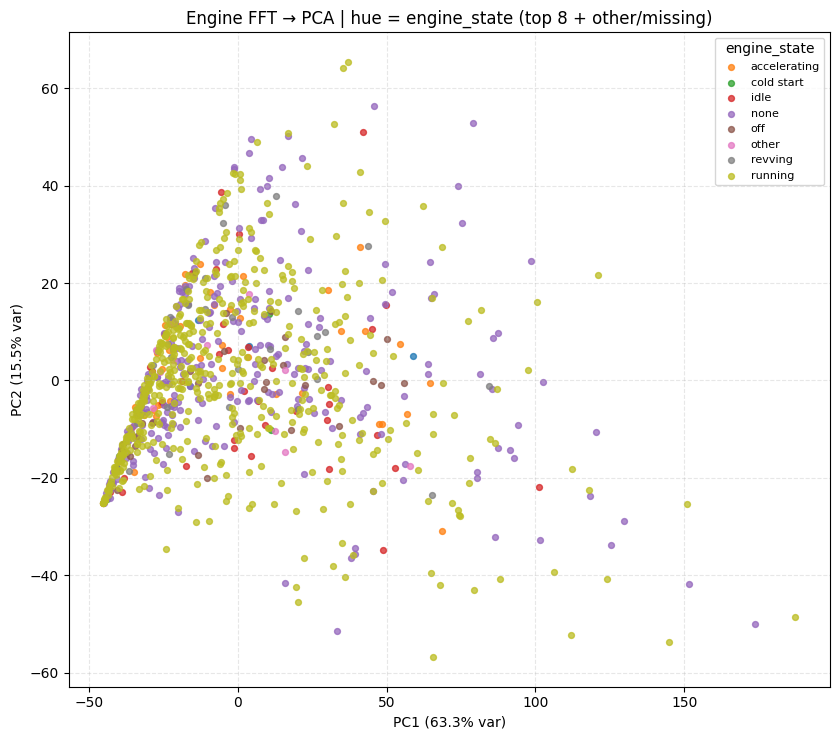

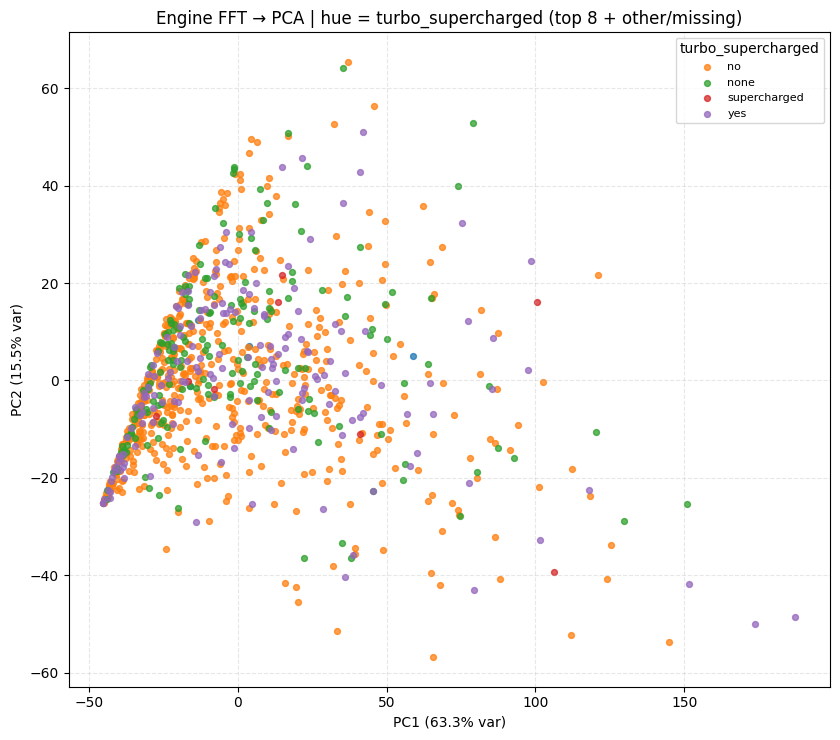

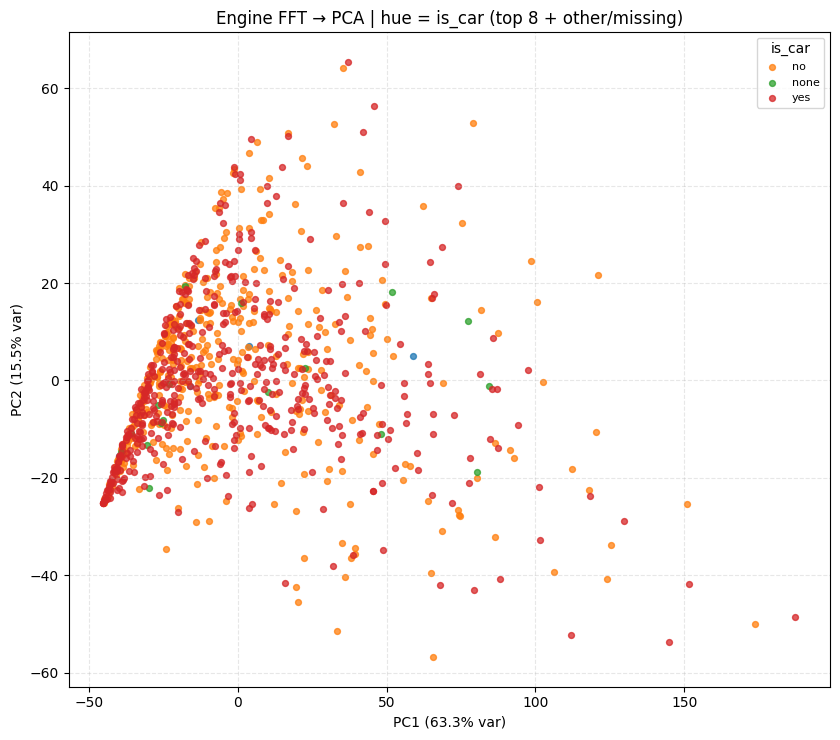

Processed: 937 clips | Missing files: 0 | Failed to parse: 1
Plotted 9 hue columns.


In [2]:

# ---- requirements (install if needed) ----
# pip install pandas numpy librosa scikit-learn matplotlib tqdm pyarrow

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# ----------------- config -----------------
PARQUET_PATH = "download/engine_metadata_combined.parquet"  # your file
AUDIO_DIR_CANDIDATES = [
    "Download/engine_downloads",
    "download/engine_downloads",
    "Download/download_engine",
    "download/download_engine",
]

TARGET_SR = 22050       # resample for consistency
N_FFT = 4096            # FFT size for STFT (feature length = N_FFT//2 + 1)
HOP_LENGTH = N_FFT // 4 # 75% overlap
RANDOM_STATE = 42

# Hue behavior
HUE_TOP_N = 8           # << adjust this to show top-N categories/bins per plot
SAVE_PLOTS_DIR = None   # e.g., "pca_hue_plots". If None, just show().

# Columns to exclude from hue plots (IDs/free text/dup info)
EXCLUDE_COLS = {
    "filename", "title", "description", "positive_labels", "YTID",
    "start_seconds", "end_seconds",  # timing metadata rarely useful as hue
    "PC1", "PC2"                     # will be added later; ensure excluded
}

# ----------------- helpers ----------------
def resolve_audio_path(fname: str) -> str | None:
    for d in AUDIO_DIR_CANDIDATES:
        p = os.path.join(d, fname)
        if os.path.exists(p):
            return p
    return None

def mean_fft_spectrum(path: str) -> np.ndarray:
    """
    Load audio (mono), resample to TARGET_SR, compute STFT with N_FFT,
    take magnitude^2 (power), average over time, log-compress.
    Returns shape (N_FFT//2 + 1,)
    """
    y, sr = librosa.load(path, sr=TARGET_SR, mono=True)
    if y.size == 0:
        raise ValueError("Empty audio after load.")
    S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH, window="hann"))**2
    spec = S.mean(axis=1)                 # average over time frames
    spec = np.log1p(spec)                 # log compression for stability
    return spec.astype(np.float32)

def tidy_obj_series(s: pd.Series) -> pd.Series:
    """Lowercase & strip strings; keep NaN; coerce non-strings to strings safely."""
    out = s.astype("object").copy()
    mask = out.notna()
    out.loc[mask] = out.loc[mask].apply(lambda x: str(x).strip().lower())
    return out

def map_top_n(series: pd.Series, n: int) -> pd.Series:
    """
    Keep top-n most frequent values; map the rest to 'other'. NaN -> 'missing'.
    Operates on object-typed series.
    """
    s = tidy_obj_series(series)
    s = s.fillna("missing")
    counts = s.value_counts(dropna=False)
    top_vals = set(counts.head(n).index.tolist())
    return s.where(s.isin(top_vals), other="other")

def bin_numeric(series: pd.Series, n_bins: int) -> pd.Series:
    """
    Discretize numeric series into up to n_bins using quantiles (qcut).
    Fall back to equal-width (cut) if qcut fails (e.g., many ties).
    Return string labels of intervals; NaN -> 'missing'.
    """
    s = pd.to_numeric(series, errors="coerce")
    if s.notna().sum() < 2:
        return pd.Series(["missing"] * len(s), index=s.index)

    # limit bins to unique values count
    unique_non_null = s.dropna().unique()
    n = min(n_bins, max(2, len(unique_non_null)))
    try:
        binned = pd.qcut(s, q=n, duplicates="drop")
    except Exception:
        binned = pd.cut(s, bins=n)

    # Convert Interval to neat strings
    labels = binned.astype(str)
    labels = labels.where(~s.isna(), other="missing")
    return labels

# --------------- main routine ------------
def main():
    # Load metadata
    df = pd.read_parquet(PARQUET_PATH)

    # Optional: normalize a commonly used column (not required for loop)
    if "is_car" in df.columns:
        df["is_car"] = tidy_obj_series(df["is_car"])

    features = []
    used_filenames = []
    meta_rows = []  # keep aligned metadata rows for used clips
    missing = 0
    failed = 0

    # Compute features
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing audio"):
        fname = str(row.get("filename", ""))
        apath = resolve_audio_path(fname)
        if not fname or apath is None:
            missing += 1
            continue
        try:
            feat = mean_fft_spectrum(apath)  # shape (N_FFT//2 + 1,)
            features.append(feat)
            used_filenames.append(fname)
            meta_rows.append(row.to_dict())
        except Exception:
            failed += 1

    if len(features) == 0:
        raise RuntimeError("No features extracted. Check paths and file availability.")

    X = np.vstack(features)  # (n_samples, n_features)

    # Scale + PCA to 2D
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xs = scaler.fit_transform(X)

    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca.fit_transform(Xs)
    evr = pca.explained_variance_ratio_

    # Build plot dataframe, aligned with extracted features
    meta_df = pd.DataFrame(meta_rows)
    plot_df = meta_df.copy()
    plot_df["filename"] = used_filenames
    plot_df["PC1"] = X2[:, 0]
    plot_df["PC2"] = X2[:, 1]

    # Decide which hue columns to plot
    candidate_cols = [c for c in plot_df.columns if c not in EXCLUDE_COLS]
    # drop columns that are entirely NaN or single-valued
    cols_to_plot = []
    for c in candidate_cols:
        if plot_df[c].notna().sum() == 0:
            continue
        if plot_df[c].nunique(dropna=True) <= 1:
            continue
        cols_to_plot.append(c)

    # Prepare output dir
    if SAVE_PLOTS_DIR:
        os.makedirs(SAVE_PLOTS_DIR, exist_ok=True)

    # One plot per hue column
    for col in cols_to_plot:
        s = plot_df[col]

        # Choose mapping strategy by dtype
        if pd.api.types.is_numeric_dtype(s):
            hue_series = bin_numeric(s, HUE_TOP_N)
            legend_note = f"(quantile bins ≤ {HUE_TOP_N})"
        else:
            hue_series = map_top_n(s, HUE_TOP_N)
            legend_note = f"(top {HUE_TOP_N} + other/missing)"

        tmp_df = plot_df.copy()
        tmp_df["_hue"] = hue_series

        # Scatter plot grouped by hue
        fig, ax = plt.subplots(figsize=(8.5, 7.5))
        for label, grp in tmp_df.groupby("_hue"):
            ax.scatter(grp["PC1"], grp["PC2"], s=18, alpha=0.75, label=str(label))

        ax.set_xlabel(f"PC1 ({evr[0]*100:.1f}% var)")
        ax.set_ylabel(f"PC2 ({evr[1]*100:.1f}% var)")
        ax.set_title(f"Engine FFT → PCA | hue = {col} {legend_note}")
        ax.legend(title=col, fontsize=8, loc="best")
        ax.grid(True, linestyle="--", alpha=0.3)
        plt.tight_layout()

        if SAVE_PLOTS_DIR:
            safe_col = "".join(ch if ch.isalnum() or ch in "-_." else "_" for ch in col)
            out_path = os.path.join(SAVE_PLOTS_DIR, f"pca_hue_{safe_col}.png")
            plt.savefig(out_path, dpi=160)
            plt.close(fig)
        else:
            plt.show()

    print(f"Processed: {len(features)} clips | Missing files: {missing} | Failed to parse: {failed}")
    print(f"Plotted {len(cols_to_plot)} hue columns.")
    if SAVE_PLOTS_DIR:
        print(f"Saved figures to: {os.path.abspath(SAVE_PLOTS_DIR)}")

if __name__ == "__main__":
    main()


/opt/anaconda3/envs/math-project/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[Info] Hue column: engine_configuration


Extracting features: 100%|██████████| 938/938 [01:18<00:00, 11.94it/s]
/opt/anaconda3/envs/math-project/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2374: RuntimeWarning: divide by zero encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/opt/anaconda3/envs/math-project/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2374: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/opt/anaconda3/envs/math-project/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/opt/anaconda3/envs/math-project/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2374: RuntimeWarning: divide by zero encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/opt/anaconda3/envs/math-project/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2374: RuntimeW

[Info] Outliers removed by MCD @ alpha=0.99: 525
[Info] HDBSCAN: 0 clusters, noise points: 387


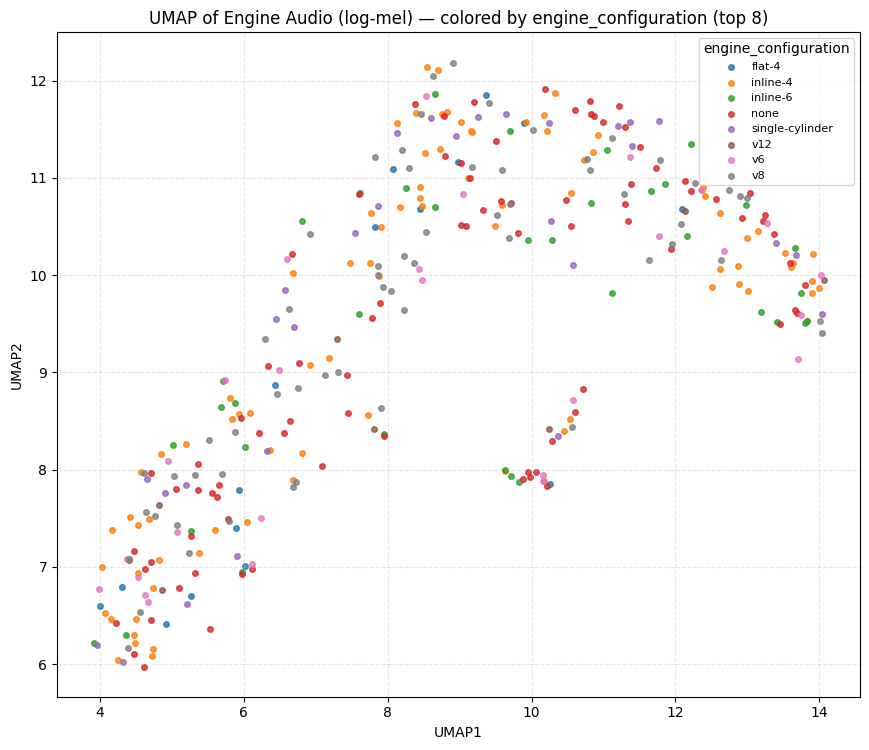

[Warn] Nothing to plot for: UMAP of Engine Audio — HDBSCAN clusters (noise hidden)
Extracted: 912 clips | Missing files: 0 | Decode errors: 0 | QA dropped: 26
Outliers removed (MCD): 525
Cluster sizes (no noise):
Plotted hue = 'engine_configuration' (top 8; other/missing hidden=True/True)


In [5]:
# ---- requirements (install if needed) ----
# pip install pandas numpy librosa scikit-learn umap-learn hdbscan matplotlib tqdm pyarrow

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler, StandardScaler, normalize
from sklearn.covariance import MinCovDet
from scipy.stats import chi2

import umap
import hdbscan

# ===================== CONFIG =====================
PARQUET_PATH = "download/engine_metadata_combined.parquet"

AUDIO_DIR_CANDIDATES = [
    "Download/engine_downloads",
    "download/engine_downloads",
    "Download/download_engine",
    "download/download_engine",
]

# Audio / features
TARGET_SR = 22050
N_FFT = 2048
HOP_LENGTH = 256
N_MELS = 96
FMIN = 20
FMAX = None  # defaults to sr/2

# QA thresholds
MIN_DURATION_SEC = 3.0            # skip if too short after load
MAX_CLIP_RATIO = 0.03             # >3% clipped samples => drop
MIN_RMS_DBFS = -45.0              # mean frame RMS below this => drop as too silent
MAX_FLATNESS_MEDIAN = 0.90        # very flat spectra => likely noise => drop

# Outlier removal (MCD robust Mahalanobis)
USE_OUTLIERS = True
MCD_ALPHA = 0.99                  # keep ≈99% under chi-square (tune 0.975–0.995)

# UMAP embedding
UMAP_N_NEIGHBORS = 30
UMAP_MIN_DIST = 0.1
UMAP_METRIC = "cosine"
RANDOM_STATE = 42

# HDBSCAN clustering (on robustly scaled inlier features)
USE_HDBSCAN = True
HDBSCAN_MIN_CLUSTER_SIZE = 20
HDBSCAN_MIN_SAMPLES = None        # None => let HDBSCAN infer

# Plotting (hue by metadata feature)
HUE_COLUMN = "engine_configuration"  # e.g., "vehicle_type" or "engine_type" or "is_car"; if None, auto-picks
HUE_TOP_N = 8
HIDE_OTHER = True
HIDE_MISSING = True
SAVE_PLOTS_DIR = None  # e.g., "plots_umap"; if None => show()

# Columns to ignore as hue candidates
EXCLUDE_COLS = {
    "filename", "title", "description", "positive_labels", "YTID",
    "start_seconds", "end_seconds", "PC1", "PC2"
}
# ===================================================


# ----------------- helpers -----------------
def resolve_audio_path(fname: str) -> str | None:
    for d in AUDIO_DIR_CANDIDATES:
        p = os.path.join(d, fname)
        if os.path.exists(p):
            return p
    return None

def qa_checks(y: np.ndarray, sr: int) -> bool:
    """Return True if clip passes QA thresholds."""
    if y is None or y.size == 0:
        return False
    dur = y.size / sr
    if dur < MIN_DURATION_SEC:
        return False
    # clipping ratio
    clip_ratio = (np.abs(y) >= 0.999).mean()
    if clip_ratio > MAX_CLIP_RATIO:
        return False
    # loudness via RMS (dBFS approx: assume signal scaled -1..1)
    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=HOP_LENGTH).squeeze()
    rms_dbfs = 20 * np.log10(np.maximum(rms, 1e-8))
    if np.nanmean(rms_dbfs) < MIN_RMS_DBFS:
        return False
    # spectral flatness (median across frames)
    S_flat = librosa.feature.spectral_flatness(y=y, n_fft=N_FFT, hop_length=HOP_LENGTH).squeeze()
    if np.nanmedian(S_flat) > MAX_FLATNESS_MEDIAN:
        return False
    return True

def extract_logmel_features(y: np.ndarray, sr: int) -> np.ndarray:
    """
    Log-mel features (median + IQR across time) + spectral stats (centroid/rolloff/flatness).
    Returns a 1D feature vector (~198 dims for N_MELS=96).
    """
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH,
        n_mels=N_MELS, fmin=FMIN, fmax=FMAX
    )
    S_db = librosa.power_to_db(S, ref=1.0)  # shape (n_mels, n_frames)

    # robust pooling across time
    med = np.median(S_db, axis=1)
    q25 = np.percentile(S_db, 25, axis=1)
    q75 = np.percentile(S_db, 75, axis=1)
    iqr = q75 - q25

    # spectral stats
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH).squeeze()
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, roll_percent=0.95).squeeze()
    flatness = librosa.feature.spectral_flatness(y=y, n_fft=N_FFT, hop_length=HOP_LENGTH).squeeze()

    stats = []
    for vec in [centroid, rolloff, flatness]:
        stats += [np.median(vec), np.percentile(vec, 75) - np.percentile(vec, 25)]

    feat = np.concatenate([med, iqr, np.asarray(stats, dtype=np.float32)])
    # per-clip L2 normalize for cosine geometry
    feat = normalize(feat.reshape(1, -1), norm="l2").ravel()
    return feat.astype(np.float32)

def tidy_obj_series(s: pd.Series) -> pd.Series:
    out = s.astype("object").copy()
    mask = out.notna()
    out.loc[mask] = out.loc[mask].apply(lambda x: str(x).strip().lower())
    return out

def map_top_n(series: pd.Series, n: int) -> pd.Series:
    s = tidy_obj_series(series)
    s = s.fillna("missing")
    counts = s.value_counts(dropna=False)
    top_vals = set(counts.head(n).index.tolist())
    mapped = s.where(s.isin(top_vals), other="other")
    return mapped

def bin_numeric_top_n(series: pd.Series, top_n: int, max_bins: int = 12) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce")
    if s.notna().sum() < 2:
        return pd.Series(["missing"] * len(s), index=s.index)
    unique_non_null = s.dropna().unique()
    q = min(max_bins, max(2, len(unique_non_null)))
    try:
        binned = pd.qcut(s, q=q, duplicates="drop")
    except Exception:
        binned = pd.cut(s, bins=q)
    labels = binned.astype(str)
    labels = labels.where(~s.isna(), other="missing")
    counts = labels.value_counts(dropna=False)
    top_vals = set(counts.head(top_n).index.tolist())
    mapped = labels.where(labels.isin(top_vals) | (labels == "missing"), other="other")
    return mapped

def robust_mahalanobis_mask(X: np.ndarray, alpha: float = 0.99, random_state: int = 42):
    """
    Robust Mahalanobis distances using MinCovDet on RobustScaled features.
    Returns inlier mask (bool), squared distances, and threshold.
    """
    Xs = RobustScaler().fit_transform(X)
    mcd = MinCovDet(random_state=random_state).fit(Xs)
    md2 = mcd.mahalanobis(Xs)
    thr = chi2.ppf(alpha, df=Xs.shape[1])
    inliers = md2 <= thr
    return inliers, md2, thr

def auto_pick_hue_column(df: pd.DataFrame) -> str:
    # prefer common audio metadata fields if present
    prefs = ["vehicle_type", "engine_type", "engine_configuration", "fuel_type", "is_car", "brand", "model", "turbo_supercharged", "engine_state"]
    for c in prefs:
        if c in df.columns and df[c].notna().sum() > 0 and df[c].nunique(dropna=True) > 1:
            return c
    # otherwise choose the non-excluded column with highest cardinality but not too high (≤50)
    candidates = [c for c in df.columns if c not in EXCLUDE_COLS]
    candidates = [c for c in candidates if df[c].nunique(dropna=True) > 1]
    if not candidates:
        return "is_car" if "is_car" in df.columns else df.columns[0]
    ranked = sorted(candidates, key=lambda c: min(df[c].nunique(dropna=True), 50), reverse=True)
    return ranked[0]

# ----------------- main -----------------
def main():
    # Load metadata
    meta_all = pd.read_parquet(PARQUET_PATH)

    # Choose hue column
    hue_col = HUE_COLUMN or auto_pick_hue_column(meta_all)
    print(f"[Info] Hue column: {hue_col}")

    features = []
    keep_rows = []
    used_filenames = []
    n_missing_files = 0
    n_failed_decode = 0
    n_qa_dropped = 0

    # Extract features
    for _, row in tqdm(meta_all.iterrows(), total=len(meta_all), desc="Extracting features"):
        fname = str(row.get("filename", ""))
        apath = resolve_audio_path(fname)
        if not fname or apath is None:
            n_missing_files += 1
            continue
        try:
            y, sr = librosa.load(apath, sr=TARGET_SR, mono=True)
        except Exception:
            n_failed_decode += 1
            continue

        if not qa_checks(y, sr):
            n_qa_dropped += 1
            continue

        try:
            feat = extract_logmel_features(y, sr)  # ~198-D
        except Exception:
            n_failed_decode += 1
            continue

        features.append(feat)
        keep_rows.append(row.to_dict())
        used_filenames.append(fname)

    if len(features) == 0:
        raise RuntimeError("No features extracted. Check paths / QA thresholds.")

    X = np.vstack(features)
    meta_df = pd.DataFrame(keep_rows)
    meta_df["filename"] = used_filenames

    # ------------- Outlier removal (MCD) -------------
    if USE_OUTLIERS and X.shape[0] >= 20:
        inliers, md2, thr = robust_mahalanobis_mask(X, alpha=MCD_ALPHA, random_state=RANDOM_STATE)
        n_out = int((~inliers).sum())
        print(f"[Info] Outliers removed by MCD @ alpha={MCD_ALPHA}: {n_out}")
        X = X[inliers]
        meta_df = meta_df.loc[inliers].reset_index(drop=True)
    else:
        print("[Info] Outlier removal skipped or insufficient samples.")
        n_out = 0

    # ------------- Scale for clustering/embedding -------------
    Xs = RobustScaler().fit_transform(X)

    # ------------- HDBSCAN clustering -------------
    if USE_HDBSCAN:
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
            min_samples=HDBSCAN_MIN_SAMPLES,
            metric="euclidean"
        )
        cluster_labels = clusterer.fit_predict(Xs)  # -1 = noise
        meta_df["_cluster"] = cluster_labels
        n_noise = int((cluster_labels == -1).sum())
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        print(f"[Info] HDBSCAN: {n_clusters} clusters, noise points: {n_noise}")
    else:
        meta_df["_cluster"] = -1

    # ------------- UMAP embedding (cosine) -------------
    reducer = umap.UMAP(
        n_neighbors=UMAP_N_NEIGHBORS,
        min_dist=UMAP_MIN_DIST,
        metric=UMAP_METRIC,
        random_state=RANDOM_STATE
    )
    emb = reducer.fit_transform(Xs)  # shape (n_samples, 2)
    meta_df["UMAP1"] = emb[:, 0]
    meta_df["UMAP2"] = emb[:, 1]

    # ------------- Build hue mapping for chosen feature -------------
    if hue_col not in meta_df.columns:
        print(f"[Warn] Hue column '{hue_col}' not found. Falling back to '_cluster'.")
        hue_col = "_cluster"

    s = meta_df[hue_col]
    if pd.api.types.is_numeric_dtype(s):
        hue_series = bin_numeric_top_n(s, top_n=HUE_TOP_N, max_bins=12)
    else:
        hue_series = map_top_n(s, HUE_TOP_N)

    meta_df["_hue"] = hue_series.astype(str)

    # Optionally hide 'other'/'missing' in metadata-colored plot
    mask_meta_plot = np.ones(len(meta_df), dtype=bool)
    if HIDE_OTHER:
        mask_meta_plot &= (meta_df["_hue"].str.lower() != "other")
    if HIDE_MISSING:
        mask_meta_plot &= (meta_df["_hue"].str.lower() != "missing")

    # ------------- Plot 1: UMAP colored by chosen metadata feature -------------
    def scatter_by(series, title, mask=None, legend_title=None, save_name=None):
        dfp = meta_df if mask is None else meta_df.loc[mask]
        if dfp.empty:
            print(f"[Warn] Nothing to plot for: {title}")
            return
        fig, ax = plt.subplots(figsize=(8.8, 7.6))
        for label, grp in dfp.groupby(series):
            ax.scatter(grp["UMAP1"], grp["UMAP2"], s=16, alpha=0.8, label=str(label))
        ax.set_title(title)
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.legend(title=legend_title or series, fontsize=8, loc="best")
        plt.tight_layout()
        if SAVE_PLOTS_DIR:
            os.makedirs(SAVE_PLOTS_DIR, exist_ok=True)
            out = os.path.join(SAVE_PLOTS_DIR, save_name)
            plt.savefig(out, dpi=160)
            plt.close(fig)
        else:
            plt.show()

    scatter_by(
        series="_hue",
        title=f"UMAP of Engine Audio (log-mel) — colored by {hue_col} (top {HUE_TOP_N})",
        mask=mask_meta_plot,
        legend_title=hue_col,
        save_name=f"umap_by_{hue_col}.png" if SAVE_PLOTS_DIR else None,
    )

    # ------------- Plot 2: UMAP colored by HDBSCAN clusters -------------
    if USE_HDBSCAN:
        mask_cls = (meta_df["_cluster"] >= 0)  # hide noise
        scatter_by(
            series="_cluster",
            title=f"UMAP of Engine Audio — HDBSCAN clusters (noise hidden)",
            mask=mask_cls,
            legend_title="cluster",
            save_name="umap_hdbscan.png" if SAVE_PLOTS_DIR else None,
        )

    # ------------- Stats -------------
    print(f"Extracted: {len(features)} clips | Missing files: {n_missing_files} | Decode errors: {n_failed_decode} | QA dropped: {n_qa_dropped}")
    print(f"Outliers removed (MCD): {n_out}")
    if USE_HDBSCAN:
        counts = meta_df.loc[meta_df['_cluster'] >= 0, '_cluster'].value_counts().sort_index()
        print("Cluster sizes (no noise):")
        for k, v in counts.items():
            print(f"  cluster {k}: {v} samples")
    print(f"Plotted hue = '{hue_col}' (top {HUE_TOP_N}; other/missing hidden={HIDE_OTHER}/{HIDE_MISSING})")
    if SAVE_PLOTS_DIR:
        print(f"Saved figures in: {os.path.abspath(SAVE_PLOTS_DIR)}")

if __name__ == "__main__":
    main()


In [8]:
# ==== Engine Sound Subspace Analysis ====
# Requirements (install if needed):
# pip install pandas numpy librosa scikit-learn matplotlib tqdm scipy umap-learn pyarrow

import os, json, math, itertools, warnings
from dataclasses import dataclass
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from scipy.linalg import subspace_angles

warnings.filterwarnings("ignore", category=UserWarning)

# ----------------- CONFIG -----------------
PARQUET_PATH = "Download/engine_metadata_combined.parquet"
AUDIO_DIR = "Download/engine_downloads"
LABEL_COL = "is_car"                      # values: "yes", "no", "none"
SR = 22050
N_MFCC = 30
N_MELS = 64
HOP = 512
N_FFT = 2048
DIM_VARIANCE_CUTOFF = 0.95                # select d_c via cumulative variance (e.g., 0.90–0.98)
MIN_PER_CLASS = 25                        # drop classes with fewer items
N_BOOTSTRAPS = 40                         # for subspace stability
BOOT_SUBSAMPLE_FRAC = 0.7
DO_AUGMENT = False                        # set True to test subspace stability to augmentations
NOISE_SNR_DB = 20.0
PITCH_STEPS = 0.5
STRETCH_FACTOR = 1.05
CV_FOLDS = 5
RANDOM_STATE = 0
OUTDIR = "analysis_outputs"
CACHE_FEATS = True
CACHE_FILE = os.path.join(OUTDIR, "clip_features.parquet")
# ------------------------------------------

rng = np.random.default_rng(RANDOM_STATE)
os.makedirs(OUTDIR, exist_ok=True)

@dataclass
class BasisInfo:
    U: np.ndarray      # D x d basis
    d: int             # intrinsic dimension
    eigvals: np.ndarray
    evr: np.ndarray    # explained variance ratio (full)

def _safe_path(fname: str) -> str:
    f = str(fname)
    if not f.lower().endswith(".wav"):
        f = f + ".wav"
    return os.path.join(AUDIO_DIR, f)

def _exists(fname: str) -> bool:
    try:
        return os.path.isfile(_safe_path(fname))
    except Exception:
        return False

def add_noise_to_snr(y, snr_db=20.0):
    if len(y) == 0:
        return y
    p_sig = np.mean(y**2) + 1e-12
    snr_lin = 10**(snr_db/10)
    p_noise = p_sig / snr_lin
    noise = rng.normal(0, math.sqrt(p_noise), size=y.shape)
    return y + noise

def clip_features_from_audio(y, sr=SR, n_mfcc=N_MFCC, n_mels=N_MELS):
    # Power spectrogram
    S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP))**2
    mel = librosa.feature.melspectrogram(S=S, sr=sr, n_mels=n_mels)
    logmel = librosa.power_to_db(mel + 1e-12)

    # MFCCs and deltas (use log-mel for better robustness)
    mfcc = librosa.feature.mfcc(S=logmel, n_mfcc=n_mfcc)
    d1 = librosa.feature.delta(mfcc)
    d2 = librosa.feature.delta(mfcc, order=2)

    # Spectral descriptors
    spec_cent = librosa.feature.spectral_centroid(S=S, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(S=S, sr=sr)
    spec_flat = librosa.feature.spectral_flatness(S=S)
    rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr)

    # Stack all framewise features
    feats = np.vstack([mfcc, d1, d2, spec_cent, spec_bw, spec_flat, rolloff])

    # Temporal pooling (mean, std, 10th, 90th)
    pooled = np.concatenate([
        feats.mean(axis=1), feats.std(axis=1),
        np.percentile(feats, 10, axis=1), np.percentile(feats, 90, axis=1)
    ])
    return pooled  # shape: F*4

def extract_clip_features(path):
    y, sr = librosa.load(path, sr=SR, mono=True)
    # normalize amplitude
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))
    return clip_features_from_audio(y, sr=sr)

def extract_with_augmentations(path):
    y, sr = librosa.load(path, sr=SR, mono=True)
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))

    feats = [clip_features_from_audio(y, sr)]
    # augmentations
    yn = add_noise_to_snr(y, NOISE_SNR_DB)
    feats.append(clip_features_from_audio(yn, sr))
    yp = librosa.effects.pitch_shift(y, sr=sr, n_steps=PITCH_STEPS)
    feats.append(clip_features_from_audio(yp, sr))
    ys = librosa.effects.time_stretch(y, rate=STRETCH_FACTOR)
    # match length by trimming/padding to original
    L = min(len(y), len(ys))
    feats.append(clip_features_from_audio(ys[:L], sr))
    return np.vstack(feats)  # 4 x D

def subspace_affinity(U, V):
    # average cos^2 of principal angles (higher = more aligned)
    th = subspace_angles(U, V)
    d = min(U.shape[1], V.shape[1])
    return float(np.mean(np.cos(th[:d])**2))

def residual_to_subspace(x, U):
    return float(np.linalg.norm(x - U @ (U.T @ x)))

def ensure_cache(df_subset):
    """Optionally cache features to speed up re-runs."""
    if (not CACHE_FEATS) or (not os.path.isfile(CACHE_FILE)):
        return None

    try:
        cache = pd.read_parquet(CACHE_FILE)
        have = set(cache["filename"].astype(str).tolist())
        need = set(df_subset["filename"].astype(str).tolist())
        if need.issubset(have):
            return cache.set_index("filename")
        return None
    except Exception:
        return None

def save_cache(records):
    if not CACHE_FEATS:
        return
    cache_df = pd.DataFrame(records)
    cache_df.to_parquet(CACHE_FILE, index=False)

# ===================== LOAD DATA =====================
data = pd.read_parquet(PARQUET_PATH)

assert "filename" in data.columns, "Expected 'filename' column in parquet."
assert LABEL_COL in data.columns, f"Expected '{LABEL_COL}' column in parquet."

# Standardize label text
data[LABEL_COL] = data[LABEL_COL].astype(str).str.strip().str.lower()

# Keep rows with existing audio files
data["path"] = data["filename"].apply(_safe_path)
mask_exists = data["path"].apply(os.path.isfile)
if mask_exists.sum() == 0:
    raise FileNotFoundError("No WAVs found under Download/engine_downloads matching the filenames in the parquet.")
data = data[mask_exists].copy()

# Keep classes with enough examples
vals, counts = np.unique(data[LABEL_COL], return_counts=True)
valid_classes = set(v for v, c in zip(vals, counts) if c >= MIN_PER_CLASS)
data = data[data[LABEL_COL].isin(valid_classes)].copy()
classes = sorted(data[LABEL_COL].unique().tolist())
print(f"Classes kept (≥{MIN_PER_CLASS}): {classes}")

# ================== FEATURE EXTRACTION ==================
print("Extracting features...")
cache = ensure_cache(data)
records = []
X_list, y_list, name_list = [], [], []

if cache is not None:
    # All needed are in cache
    cache = cache.loc[data["filename"].astype(str)]
    feats = np.vstack(cache["feat"].apply(lambda z: np.array(json.loads(z))).tolist())
    X_list = [feats]
    y_list = [data[LABEL_COL].values]
    name_list = [data["filename"].astype(str).values]
else:
    for _, row in tqdm(data.iterrows(), total=len(data)):
        path = row["path"]
        try:
            if DO_AUGMENT:
                # 4 variants per clip (original + 3 augs)
                F = extract_with_augmentations(path)
                for k in range(F.shape[0]):
                    X_list.append(F[k])
                    y_list.append(row[LABEL_COL])
                    name_list.append(f"{row['filename']}#{k}")
            else:
                f = extract_clip_features(path)
                X_list.append(f)
                y_list.append(row[LABEL_COL])
                name_list.append(row["filename"])
            # cache raw
            records.append({
                "filename": row["filename"],
                "feat": json.dumps(list(f if not DO_AUGMENT else F[0]))  # cache only original
            })
        except Exception as e:
            # Skip unreadable clips
            print(f"[warn] {row['filename']}: {e}")

    if len(records) and not os.path.isfile(CACHE_FILE):
        save_cache(records)

X = np.vstack(X_list)
y = np.array(y_list)
names = np.array(name_list)
D = X.shape[1]
print(f"Feature matrix: X shape = {X.shape}, D = {D}")

# ================== STANDARDIZE ==================
scaler = StandardScaler().fit(X)
Xz = scaler.transform(X)

# ================== PER-CLASS PCA ==================
def fit_class_basis(Xc: np.ndarray, cutoff=DIM_VARIANCE_CUTOFF) -> BasisInfo:
    p = PCA(svd_solver="full").fit(Xc)
    evr = p.explained_variance_ratio_
    cum = np.cumsum(evr)
    d = int(np.searchsorted(cum, cutoff) + 1)
    d = max(1, min(d, p.components_.shape[0]))
    U = p.components_[:d].T  # D x d
    return BasisInfo(U=U, d=d, eigvals=p.explained_variance_, evr=evr)

class2basis = {}
class2dims = {}
class2eigs = {}
for c in classes:
    Xc = Xz[y == c]
    info = fit_class_basis(Xc, DIM_VARIANCE_CUTOFF)
    class2basis[c] = info
    class2dims[c] = info.d
    class2eigs[c] = info.eigvals
    print(f"[{c}] d_c={info.d}, coverage≥{DIM_VARIANCE_CUTOFF*100:.0f}%")

# Save table of intrinsic dims
pd.DataFrame({"class": classes, "d_c": [class2dims[c] for c in classes]}).to_csv(
    os.path.join(OUTDIR, "intrinsic_dims.csv"), index=False
)

# ================== PLOTS: Scree & Reconstruction ==================
print("Making scree and reconstruction plots...")

# Scree per class
plt.figure(figsize=(10, 6))
for c in classes:
    evr = class2basis[c].evr
    plt.plot(np.arange(1, len(evr)+1), evr, marker='o', label=f"{c} (d={class2dims[c]})")
plt.xlabel("PC index")
plt.ylabel("Explained variance ratio")
plt.title("Per-class Scree Plot")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "scree_per_class.png"), dpi=180)
plt.close()

# Reconstruction error vs d
plt.figure(figsize=(10, 6))
for c in classes:
    Xc = Xz[y == c]
    p = PCA(svd_solver="full").fit(Xc)
    errs = []
    for d in range(1, min(60, Xc.shape[0], Xc.shape[1]) + 1):  # cap for speed/clarity
        U = p.components_[:d].T
        proj = (Xc @ U) @ U.T
        err = np.mean(np.linalg.norm(Xc - proj, axis=1))
        errs.append(err)
    plt.plot(np.arange(1, len(errs)+1), errs, marker='o', label=f"{c}")
plt.xlabel("Dimension d")
plt.ylabel("Mean reconstruction error (z-space)")
plt.title("Reconstruction Error vs d (per class)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "reconstruction_vs_d.png"), dpi=180)
plt.close()

# ================== STABILITY: Bootstrapped Affinity ==================
print("Evaluating subspace stability (bootstraps)...")
stability = {c: [] for c in classes}
for c in classes:
    Xc = Xz[y == c]
    info_ref = class2basis[c]
    d = info_ref.d
    for _ in range(N_BOOTSTRAPS):
        n_sub = max(3, int(BOOT_SUBSAMPLE_FRAC * len(Xc)))
        idx = rng.choice(len(Xc), size=n_sub, replace=False)
        info_b = fit_class_basis(Xc[idx], DIM_VARIANCE_CUTOFF)
        # align dimensionality for fair comparison
        d_cmp = min(d, info_b.d)
        U_ref = info_ref.U[:, :d_cmp]
        U_b = info_b.U[:, :d_cmp]
        stability[c].append(subspace_affinity(U_ref, U_b))

# Boxplot
plt.figure(figsize=(8, 6))
data_box = [stability[c] for c in classes]
plt.boxplot(data_box, labels=classes, showmeans=True)
plt.ylabel("Subspace affinity (mean cos^2 θ)")
plt.title("Bootstrap Stability of Class Subspaces")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "stability_bootstrap.png"), dpi=180)
plt.close()

# ================== BETWEEN-CLASS PRINCIPAL ANGLES ==================
print("Computing between-class principal angles...")
angle_mat = pd.DataFrame(index=classes, columns=classes, dtype=float)
for c1, c2 in itertools.product(classes, classes):
    th = subspace_angles(class2basis[c1].U, class2basis[c2].U)
    angle_mat.loc[c1, c2] = float(th[0])  # smallest principal angle

fig = plt.figure(figsize=(6 + 0.4*len(classes), 5 + 0.4*len(classes)))
plt.imshow(angle_mat.values.astype(float), interpolation='nearest')
plt.colorbar(label="Smallest principal angle (radians)")
plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
plt.yticks(range(len(classes)), classes)
plt.title("Between-class Smallest Principal Angle")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "between_class_angles.png"), dpi=180)
plt.close()

angle_mat.to_csv(os.path.join(OUTDIR, "between_class_angles.csv"))

# ================== CLASSIFICATION: Nearest-Subspace (CV) ==================
print("Cross-validating Nearest-Subspace classifier...")

def fit_bases_by_class(Xz_tr, y_tr):
    bases = {}
    for c in classes:
        Xc = Xz_tr[y_tr == c]
        if len(Xc) < 3:
            # fallback: 1D basis = first PC of whatever is available
            info = fit_class_basis(Xc, DIM_VARIANCE_CUTOFF)
        else:
            info = fit_class_basis(Xc, DIM_VARIANCE_CUTOFF)
        bases[c] = info
    return bases

def predict_nsc(Xz_te):
    preds = []
    for x in Xz_te:
        best_c, best_r = None, np.inf
        for c in classes:
            U = bases[c].U
            r = residual_to_subspace(x, U)
            if r < best_r:
                best_r, best_c = r, c
        preds.append(best_c)
    return np.array(preds)

# Stratified K-fold (cap by smallest class size)
counts = pd.Series(y).value_counts()
max_folds = int(counts.min())
n_splits = max(2, min(CV_FOLDS, max_folds))
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

y_true_all, y_pred_all = [], []
fold = 1
for tr_idx, te_idx in skf.split(Xz, y):
    Xtr, Xte = Xz[tr_idx], Xz[te_idx]
    ytr, yte = y[tr_idx], y[te_idx]
    bases = fit_bases_by_class(Xtr, ytr)
    yhat = []
    for x in Xte:
        best_c, best_r = None, np.inf
        for c in classes:
            U = bases[c].U
            r = residual_to_subspace(x, U)
            if r < best_r:
                best_r, best_c = r, c
        yhat.append(best_c)
    yhat = np.array(yhat)
    y_true_all.append(yte); y_pred_all.append(yhat)

    acc = accuracy_score(yte, yhat)
    f1m = f1_score(yte, yhat, average="macro")
    print(f"Fold {fold}/{n_splits}: acc={acc:.3f}, macro-F1={f1m:.3f}")
    fold += 1

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

report = classification_report(y_true_all, y_pred_all, digits=3, output_dict=True)
pd.DataFrame(report).T.to_csv(os.path.join(OUTDIR, "nsc_classification_report.csv"))

# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all, labels=classes)
fig = plt.figure(figsize=(6 + 0.4*len(classes), 5 + 0.4*len(classes)))
plt.imshow(cm, interpolation='nearest')
plt.colorbar(label="Count")
plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
plt.yticks(range(len(classes)), classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Nearest-Subspace Confusion Matrix (CV)")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "nsc_confusion_matrix.png"), dpi=180)
plt.close()

# Also save a plain-text summary
with open(os.path.join(OUTDIR, "summary.txt"), "w") as f:
    f.write("== Intrinsic dimensions (per class) ==\n")
    for c in classes:
        f.write(f"{c}: d={class2dims[c]}\n")
    f.write("\n== NSC CV classification report ==\n")
    for k, v in report.items():
        f.write(f"{k}: {v}\n")

print("\nDone. Artifacts written to:", OUTDIR)
print(" - scree_per_class.png")
print(" - reconstruction_vs_d.png")
print(" - stability_bootstrap.png")
print(" - between_class_angles.png & .csv")
print(" - nsc_confusion_matrix.png")
print(" - intrinsic_dims.csv")
print(" - nsc_classification_report.csv")
print(" - summary.txt")


Classes kept (≥25): ['no', 'yes']
Extracting features...


 66%|██████▋   | 607/915 [00:17<00:08, 35.32it/s]

[warn] 1zFTs3nIcyg_60_70.wav: zero-size array to reduction operation maximum which has no identity


100%|██████████| 915/915 [00:26<00:00, 34.40it/s]


Feature matrix: X shape = (914, 376), D = 376
[no] d_c=95, coverage≥95%
[yes] d_c=105, coverage≥95%
Making scree and reconstruction plots...
Evaluating subspace stability (bootstraps)...


/var/folders/nm/b_657b8s0_n7nkw6gl0z9shw0000gq/T/ipykernel_12365/4250308667.py:312: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=classes, showmeans=True)


Computing between-class principal angles...
Cross-validating Nearest-Subspace classifier...
Fold 1/5: acc=0.519, macro-F1=0.445
Fold 2/5: acc=0.530, macro-F1=0.429
Fold 3/5: acc=0.497, macro-F1=0.389
Fold 4/5: acc=0.541, macro-F1=0.454
Fold 5/5: acc=0.484, macro-F1=0.411

Done. Artifacts written to: analysis_outputs
 - scree_per_class.png
 - reconstruction_vs_d.png
 - stability_bootstrap.png
 - between_class_angles.png & .csv
 - nsc_confusion_matrix.png
 - intrinsic_dims.csv
 - nsc_classification_report.csv
 - summary.txt


In [9]:
# ==== Engine Sound Subspace Analysis (Improved) ====
# pip install pandas numpy librosa scikit-learn matplotlib tqdm scipy umap-learn pyarrow

import os, json, math, itertools, warnings
from dataclasses import dataclass
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from scipy.linalg import subspace_angles

warnings.filterwarnings("ignore", category=UserWarning)

# ----------------- CONFIG -----------------
PARQUET_PATH = "Download/engine_metadata_combined.parquet"
AUDIO_DIR = "Download/engine_downloads"
LABEL_COL = "is_car"                      # "yes", "no", "none"

# Feature config
SR = 22050
N_MFCC = 30
N_MELS = 64
HOP = 512
N_FFT = 2048
SIMPLE_FEATURES = True   # True = log-mel stats only (cleaner); False = MFCC+spectral bundle

# Subspace config
DIM_VARIANCE_CUTOFF = 0.95     # used only for diagnostic plots & provisional fits
MIN_PER_CLASS = 25
OUTLIER_TRIM_FRAC = 0.10       # trim worst 10% per class (set 0 to disable)

# Stability & plotting
N_BOOTSTRAPS = 40
BOOT_SUBSAMPLE_FRAC = 0.7

# Global PCA (denoise) before per-class
GLOBAL_VARIANCE_CUTOFF = 0.95  # keep enough comps to reach this variance
GLOBAL_MAX_D = 100             # safety cap after cutoff

# Shared dimension + scoring selection by CV
CV_FOLDS = 5
RANDOM_STATE = 0
CANDIDATE_DIMS = [5, 10, 15, 20, 30, 40, 60]  # shared d search
SCORING_RULES = ["residual_normed", "proj_energy"]  # candidates

# Output
OUTDIR = "analysis_outputs2"
CACHE_FEATS = True
CACHE_FILE = os.path.join(OUTDIR, "clip_features.parquet")
# ------------------------------------------

rng = np.random.default_rng(RANDOM_STATE)
os.makedirs(OUTDIR, exist_ok=True)

@dataclass
class BasisInfo:
    U: np.ndarray      # D x d basis
    d: int
    eigvals: np.ndarray
    evr: np.ndarray

def _safe_path(fname: str) -> str:
    f = str(fname)
    if not f.lower().endswith(".wav"):
        f = f + ".wav"
    return os.path.join(AUDIO_DIR, f)

def add_noise_to_snr(y, snr_db=20.0):
    if len(y) == 0:
        return y
    p_sig = np.mean(y**2) + 1e-12
    snr_lin = 10**(snr_db/10)
    p_noise = p_sig / snr_lin
    noise = rng.normal(0, math.sqrt(p_noise), size=y.shape)
    return y + noise

# --------- Feature extraction ---------
def clip_features_from_audio_simple(y, sr=SR, n_mels=N_MELS):
    # log-mel spectrogram -> global stats (mean, std, p10, p90) per mel bin
    S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP))**2
    mel = librosa.feature.melspectrogram(S=S, sr=sr, n_mels=n_mels)
    logmel = librosa.power_to_db(mel + 1e-12)
    stats = np.concatenate([
        logmel.mean(axis=1), logmel.std(axis=1),
        np.percentile(logmel, 10, axis=1), np.percentile(logmel, 90, axis=1)
    ])
    return stats

def clip_features_from_audio_full(y, sr=SR, n_mfcc=N_MFCC, n_mels=N_MELS):
    S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP))**2
    mel = librosa.feature.melspectrogram(S=S, sr=sr, n_mels=n_mels)
    logmel = librosa.power_to_db(mel + 1e-12)

    mfcc = librosa.feature.mfcc(S=logmel, n_mfcc=n_mfcc)
    d1 = librosa.feature.delta(mfcc)
    d2 = librosa.feature.delta(mfcc, order=2)

    spec_cent = librosa.feature.spectral_centroid(S=S, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(S=S, sr=sr)
    spec_flat = librosa.feature.spectral_flatness(S=S)
    rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr)

    feats = np.vstack([mfcc, d1, d2, spec_cent, spec_bw, spec_flat, rolloff])
    stats = np.concatenate([
        feats.mean(axis=1), feats.std(axis=1),
        np.percentile(feats, 10, axis=1), np.percentile(feats, 90, axis=1)
    ])
    return stats

def extract_clip_features(path):
    y, sr = librosa.load(path, sr=SR, mono=True)
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))
    if SIMPLE_FEATURES:
        return clip_features_from_audio_simple(y, sr)
    else:
        return clip_features_from_audio_full(y, sr)

def subspace_affinity(U, V):
    th = subspace_angles(U, V)
    d = min(U.shape[1], V.shape[1])
    return float(np.mean(np.cos(th[:d])**2))

def residual_to_subspace(x, U):
    return float(np.linalg.norm(x - U @ (U.T @ x)))

def projection_energy(x, U):
    coeff = U.T @ x
    return float(np.dot(coeff, coeff))  # ||U^T x||^2

def ensure_cache(df_subset):
    if (not CACHE_FEATS) or (not os.path.isfile(CACHE_FILE)):
        return None
    try:
        cache = pd.read_parquet(CACHE_FILE)
        have = set(cache["filename"].astype(str).tolist())
        need = set(df_subset["filename"].astype(str).tolist())
        if need.issubset(have):
            return cache.set_index("filename")
        return None
    except Exception:
        return None

def save_cache(records):
    if not CACHE_FEATS:
        return
    cache_df = pd.DataFrame(records)
    cache_df.to_parquet(CACHE_FILE, index=False)

# ===================== LOAD DATA =====================
data = pd.read_parquet(PARQUET_PATH)
assert "filename" in data.columns, "Expected 'filename' column in parquet."
assert LABEL_COL in data.columns, f"Expected '{LABEL_COL}' column."

data[LABEL_COL] = data[LABEL_COL].astype(str).str.strip().str.lower()
data["path"] = data["filename"].apply(_safe_path)
mask_exists = data["path"].apply(os.path.isfile)
if mask_exists.sum() == 0:
    raise FileNotFoundError("No WAVs found under Download/engine_downloads matching the filenames in the parquet.")
data = data[mask_exists].copy()

# Keep classes with enough examples
vals, counts = np.unique(data[LABEL_COL], return_counts=True)
valid_classes = set(v for v, c in zip(vals, counts) if c >= MIN_PER_CLASS)
data = data[data[LABEL_COL].isin(valid_classes)].copy()
classes = sorted(data[LABEL_COL].unique().tolist())
print(f"Classes kept (≥{MIN_PER_CLASS}): {classes}")

# ================== FEATURE EXTRACTION ==================
print("Extracting features...")
os.makedirs(OUTDIR, exist_ok=True)
cache = ensure_cache(data)
records = []
X_list, y_list, name_list = [], [], []

if cache is not None:
    cache = cache.loc[data["filename"].astype(str)]
    feats = np.vstack(cache["feat"].apply(lambda z: np.array(json.loads(z))).tolist())
    X_list = [feats]
    y_list = [data[LABEL_COL].values]
    name_list = [data["filename"].astype(str).values]
else:
    for _, row in tqdm(data.iterrows(), total=len(data)):
        try:
            f = extract_clip_features(row["path"])
            X_list.append(f)
            y_list.append(row[LABEL_COL])
            name_list.append(row["filename"])
            records.append({"filename": row["filename"], "feat": json.dumps(list(f))})
        except Exception as e:
            print(f"[warn] {row['filename']}: {e}")
    if len(records) and not os.path.isfile(CACHE_FILE):
        save_cache(records)

X = np.vstack(X_list)
y = np.array(y_list)
names = np.array(name_list)
D = X.shape[1]
print(f"Feature matrix: X shape = {X.shape}, D = {D}")

# ================== STANDARDIZE & GLOBAL PCA ==================
scaler = StandardScaler().fit(X)
Xz = scaler.transform(X)

# Global PCA: denoise/compact
p_global = PCA(svd_solver="full").fit(Xz)
evr = p_global.explained_variance_ratio_
cum = np.cumsum(evr)
d_glob = int(np.searchsorted(cum, GLOBAL_VARIANCE_CUTOFF) + 1)
d_glob = min(d_glob, GLOBAL_MAX_D, Xz.shape[1], Xz.shape[0])
U_global = p_global.components_[:d_glob].T
Xg = Xz @ U_global  # [N x d_glob]
print(f"Global PCA kept {d_glob} dims (≥{GLOBAL_VARIANCE_CUTOFF*100:.0f}% var, cap {GLOBAL_MAX_D}).")

# ================== OUTLIER TRIMMING (per class) ==================
def trim_outliers_per_class(Xg, y, trim_frac=OUTLIER_TRIM_FRAC, d_temp=20):
    if trim_frac <= 0:
        return Xg, y, np.zeros(len(y), dtype=bool)

    keep_mask = np.ones(len(y), dtype=bool)
    outlier_mask = np.zeros(len(y), dtype=bool)
    for c in classes:
        idx = np.where(y == c)[0]
        Xc = Xg[idx]
        # provisional basis at small d (robust-ish)
        d_use = min(d_temp, Xc.shape[0], Xc.shape[1])
        pc = PCA(svd_solver="full").fit(Xc)
        Uc = pc.components_[:d_use].T
        res = np.linalg.norm(Xc - (Xc @ Uc) @ Uc.T, axis=1)
        k = int(np.floor(trim_frac * len(res)))
        if k > 0:
            worst = idx[np.argsort(res)[-k:]]
            keep_mask[worst] = False
            outlier_mask[worst] = True
    return Xg[keep_mask], y[keep_mask], outlier_mask

Xg_trim, y_trim, outlier_mask = trim_outliers_per_class(Xg, y, OUTLIER_TRIM_FRAC, d_temp=20)
print(f"Trimmed {outlier_mask.sum()} outliers ({OUTLIER_TRIM_FRAC*100:.0f}% per class).")
np.savetxt(os.path.join(OUTDIR, "trimmed_indices.txt"), np.where(outlier_mask)[0], fmt="%d")

# ================== SHARED-d & SCORING RULE SELECTION (CV) ==================
def fit_bases_shared_d(Xtr, ytr, shared_d):
    bases = {}
    for c in classes:
        Xc = Xtr[ytr == c]
        d = min(shared_d, Xc.shape[0], Xc.shape[1])
        p = PCA(svd_solver="full").fit(Xc)
        U = p.components_[:d].T
        bases[c] = U
    return bases

def predict_with_rule(Xte, bases, rule):
    preds = []
    d = list(bases.values())[0].shape[1]
    for x in Xte:
        best_c, best_score = None, -np.inf
        if rule == "residual_normed":
            # smaller residual is better -> convert to score = - r / sqrt(d)
            for c, U in bases.items():
                r = residual_to_subspace(x, U) / math.sqrt(d)
                s = -r
                if s > best_score:
                    best_score, best_c = s, c
        elif rule == "proj_energy":
            # larger projected energy per dim wins
            for c, U in bases.items():
                s = projection_energy(x, U) / d
                if s > best_score:
                    best_score, best_c = s, c
        else:
            raise ValueError("Unknown rule")
        preds.append(best_c)
    return np.array(preds)

def crossval_shared_d_rule(Xg, y, dims, rules, folds=CV_FOLDS, seed=RANDOM_STATE):
    skf = StratifiedKFold(n_splits=max(2, min(folds, int(pd.Series(y).value_counts().min()))),
                          shuffle=True, random_state=seed)
    results = []
    for d in dims:
        for rule in rules:
            y_true_all, y_pred_all = [], []
            for tr, te in skf.split(Xg, y):
                bases = fit_bases_shared_d(Xg[tr], y[tr], shared_d=d)
                yhat = predict_with_rule(Xg[te], bases, rule)
                y_true_all.append(y[te]); y_pred_all.append(yhat)
            y_true_all = np.concatenate(y_true_all)
            y_pred_all = np.concatenate(y_pred_all)
            f1m = f1_score(y_true_all, y_pred_all, average="macro")
            acc = accuracy_score(y_true_all, y_pred_all)
            results.append({"d": d, "rule": rule, "macro_f1": f1m, "acc": acc})
            print(f"[CV] d={d:>3}, rule={rule:>15} | acc={acc:.3f}, macroF1={f1m:.3f}")
    res_df = pd.DataFrame(results)
    res_df.to_csv(os.path.join(OUTDIR, "cv_shared_d_rule_grid.csv"), index=False)
    # pick best by macro-F1, break ties by accuracy, then smaller d
    res_df = res_df.sort_values(["macro_f1", "acc", "d"], ascending=[False, False, True])
    best = res_df.iloc[0].to_dict()
    return best, res_df

# Enforce d cap by global PCA dimension
CANDIDATE_DIMS = [int(d) for d in CANDIDATE_DIMS if int(d) <= int(d_glob)]
best, grid = crossval_shared_d_rule(Xg_trim, y_trim, CANDIDATE_DIMS, SCORING_RULES)
SHARED_D = int(min(int(d_glob), int(best["d"])))
BEST_RULE = best["rule"]
print(f"\nSelected SHARED_D={SHARED_D}, BEST_RULE={BEST_RULE} (macroF1={best['macro_f1']:.3f}, acc={best['acc']:.3f})")

# Fit final bases on trimmed set with shared d
bases = fit_bases_shared_d(Xg_trim, y_trim, SHARED_D)

# ================== DIAGNOSTIC: Scree & Reconstruction (post-trim, in global space) ==================
def fit_class_basis_diag(Xc: np.ndarray, cutoff=DIM_VARIANCE_CUTOFF) -> BasisInfo:
    p = PCA(svd_solver="full").fit(Xc)
    evr = p.explained_variance_ratio_
    cum = np.cumsum(evr)
    d = int(np.searchsorted(cum, cutoff) + 1)
    d = max(1, min(d, p.components_.shape[0]))
    U = p.components_[:d].T
    return BasisInfo(U=U, d=d, eigvals=p.explained_variance_, evr=evr)

class2diag = {}
class2dims = {}
for c in classes:
    Xc = Xg_trim[y_trim == c]
    info = fit_class_basis_diag(Xc, DIM_VARIANCE_CUTOFF)
    class2diag[c] = info
    class2dims[c] = info.d

pd.DataFrame({"class": classes, "d_c_diag": [class2dims[c] for c in classes]}).to_csv(
    os.path.join(OUTDIR, "intrinsic_dims_posttrim.csv"), index=False
)

# Scree
plt.figure(figsize=(10, 6))
for c in classes:
    evr = class2diag[c].evr
    plt.plot(np.arange(1, len(evr)+1), evr, marker='o', label=f"{c} (d~{class2dims[c]})")
plt.xlabel("PC index")
plt.ylabel("Explained variance ratio")
plt.title("Per-class Scree (after global PCA + trimming)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "scree_per_class_posttrim.png"), dpi=180)
plt.close()

# Reconstruction vs d
plt.figure(figsize=(10, 6))
for c in classes:
    Xc = Xg_trim[y_trim == c]
    p = PCA(svd_solver="full").fit(Xc)
    max_d_plot = min(60, Xc.shape[0], Xc.shape[1])
    errs = []
    for d in range(1, max_d_plot + 1):
        U = p.components_[:d].T
        proj = (Xc @ U) @ U.T
        err = np.mean(np.linalg.norm(Xc - proj, axis=1))
        errs.append(err)
    plt.plot(np.arange(1, len(errs)+1), errs, marker='o', label=f"{c}")
plt.xlabel("Dimension d")
plt.ylabel("Mean reconstruction error (global-PCA space)")
plt.title("Reconstruction Error vs d (post-trim)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "reconstruction_vs_d_posttrim.png"), dpi=180)
plt.close()

# ================== STABILITY (bootstraps on trimmed set, shared d) ==================
print("Evaluating subspace stability (bootstraps, post-trim)...")
stability = {c: [] for c in classes}
for c in classes:
    Xc = Xg_trim[y_trim == c]
    d = SHARED_D
    # reference basis
    p_ref = PCA(svd_solver="full").fit(Xc)
    U_ref = p_ref.components_[:d].T
    for _ in range(N_BOOTSTRAPS):
        n_sub = max(3, int(BOOT_SUBSAMPLE_FRAC * len(Xc)))
        idx = rng.choice(len(Xc), size=n_sub, replace=False)
        p_b = PCA(svd_solver="full").fit(Xc[idx])
        U_b = p_b.components_[:d].T
        stability[c].append(subspace_affinity(U_ref, U_b))

plt.figure(figsize=(8, 6))
plt.boxplot([stability[c] for c in classes], labels=classes, showmeans=True)
plt.ylabel("Subspace affinity (mean cos^2 θ)")
plt.title(f"Bootstrap Stability (shared d={SHARED_D}, post-trim)")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "stability_bootstrap_posttrim.png"), dpi=180)
plt.close()

# ================== BETWEEN-CLASS ANGLES (shared d) ==================
angle_mat = pd.DataFrame(index=classes, columns=classes, dtype=float)
for c1, c2 in itertools.product(classes, classes):
    th = subspace_angles(bases[c1], bases[c2])  # both have d=SHARED_D
    angle_mat.loc[c1, c2] = float(th[0])

plt.figure(figsize=(6 + 0.4*len(classes), 5 + 0.4*len(classes)))
plt.imshow(angle_mat.values.astype(float), interpolation='nearest')
plt.colorbar(label="Smallest principal angle (radians)")
plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
plt.yticks(range(len(classes)), classes)
plt.title(f"Between-class Smallest Principal Angle (shared d={SHARED_D})")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "between_class_angles_shared.png"), dpi=180)
plt.close()
angle_mat.to_csv(os.path.join(OUTDIR, "between_class_angles_shared.csv"))

# ================== FINAL CLASSIFICATION (on full non-trimmed set) ==================
# Evaluate on original Xg (no trimming) to avoid optimistic bias; fit bases on trimmed set.
def predict_final(Xg_eval, bases, rule):
    preds = []
    d = list(bases.values())[0].shape[1]
    for x in Xg_eval:
        best_c, best_score = None, -np.inf
        if rule == "residual_normed":
            for c, U in bases.items():
                r = residual_to_subspace(x, U) / math.sqrt(d)
                s = -r
                if s > best_score:
                    best_score, best_c = s, c
        elif rule == "proj_energy":
            for c, U in bases.items():
                s = projection_energy(x, U) / d
                if s > best_score:
                    best_score, best_c = s, c
        preds.append(best_c)
    return np.array(preds)

y_pred = predict_final(Xg, bases, BEST_RULE)
report = classification_report(y, y_pred, digits=3, output_dict=True)
pd.DataFrame(report).T.to_csv(os.path.join(OUTDIR, "nsc_classification_report_final.csv"))

cm = confusion_matrix(y, y_pred, labels=classes)
plt.figure(figsize=(6 + 0.4*len(classes), 5 + 0.4*len(classes)))
plt.imshow(cm, interpolation='nearest')
plt.colorbar(label="Count")
plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
plt.yticks(range(len(classes)), classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Nearest-Subspace Confusion Matrix (rule={BEST_RULE}, d={SHARED_D})")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "nsc_confusion_matrix_final.png"), dpi=180)
plt.close()

# ================== Baselines & summary ==================
majority = pd.Series(y).value_counts().idxmax()
maj_acc = (y == majority).mean()

# Prepare numeric stability and angle summaries (if available in scope)
try:
    stab_summary = {c: {"mean": float(np.mean(stability.get(c, []))) if len(stability.get(c, []))>0 else None,
                        "std": float(np.std(stability.get(c, []))) if len(stability.get(c, []))>0 else None}
                    for c in classes}
except Exception:
    stab_summary = {}
try:
    _angles = []
    if 'angle_mat' in globals():
        for c1 in classes:
            for c2 in classes:
                if c1 != c2:
                    _angles.append(float(angle_mat.loc[c1, c2]))
    min_angle = float(np.min(_angles)) if _angles else None
    med_angle = float(np.median(_angles)) if _angles else None
except Exception:
    min_angle, med_angle = None, None

with open(os.path.join(OUTDIR, "summary_improved.txt"), "w") as f:
    f.write(f"== Global PCA ==\nKept d_glob={d_glob} (≥{GLOBAL_VARIANCE_CUTOFF*100:.0f}% var, cap {GLOBAL_MAX_D})\n\n")
    f.write(f"== Outlier trimming ==\nTrimmed {outlier_mask.sum()} ({OUTLIER_TRIM_FRAC*100:.0f}% per class)\n\n")
    f.write(f"== Shared dimension & rule (CV) ==\nSHARED_D={SHARED_D}, BEST_RULE={BEST_RULE}\n")
    f.write("Grid search saved at cv_shared_d_rule_grid.csv\n\n")
    # Stability numeric summary
    if stab_summary:
        f.write("== Stability (bootstrap; subspace affinity) ==\n")
        for c, v in stab_summary.items():
            if v['mean'] is not None:
                f.write(f"{c}: mean={v['mean']:.3f}, std={v['std']:.3f}\n")
            else:
                f.write(f"{c}: insufficient data\n")
        f.write("\n")
    # Between-class angle numeric summary
    f.write("== Between-class angles (radians) ==\n")
    if min_angle is not None:
        f.write(f"min_offdiag={min_angle:.6f}, median_offdiag={med_angle:.6f}\n\n")
    else:
        f.write("no angles computed\n\n")
    f.write("== Final evaluation on full set ==\n")
    f.write(f"Majority baseline acc: {maj_acc:.3f} (majority='{majority}')\n")
    f.write(json.dumps(report, indent=2))

print("\nDone. Artifacts written to:", OUTDIR)
print(" - cv_shared_d_rule_grid.csv (CV selection)")
print(" - scree_per_class_posttrim.png")
print(" - reconstruction_vs_d_posttrim.png")
print(" - stability_bootstrap_posttrim.png")
print(" - between_class_angles_shared.png & .csv")
print(" - nsc_confusion_matrix_final.png")
print(" - nsc_classification_report_final.csv")
print(" - intrinsic_dims_posttrim.csv")
print(" - summary_improved.txt")


Classes kept (≥25): ['no', 'yes']
Extracting features...


  1%|          | 8/915 [00:00<00:12, 70.93it/s]

[warn] --330hg-Ocw_30_40.wav: Object of type float32 is not JSON serializable
[warn] --8puiAGLhs_30_40.wav: Object of type float32 is not JSON serializable
[warn] --Dxk606LRQ_30_40.wav: Object of type float32 is not JSON serializable
[warn] --jGnLqFsQ4_24_34.wav: Object of type float32 is not JSON serializable
[warn] --kcclzNEZQ_30_40.wav: Object of type float32 is not JSON serializable
[warn] -0HsrVfb5vc_20_30.wav: Object of type float32 is not JSON serializable
[warn] -0J9HfwJ08c_30_40.wav: Object of type float32 is not JSON serializable
[warn] -0d6GOvAoS0_0_10.wav: Object of type float32 is not JSON serializable
[warn] -0pZsnG1MAI_30_40.wav: Object of type float32 is not JSON serializable
[warn] -1O8bucXb5E_30_40.wav: Object of type float32 is not JSON serializable
[warn] -1guPbH2s3Y_27_37.wav: Object of type float32 is not JSON serializable
[warn] -26ZR9AGm7k_30_40.wav: Object of type float32 is not JSON serializable
[warn] -2GC25ao1Og_30_40.wav: Object of type float32 is not JSON 

  3%|▎         | 23/915 [00:00<00:12, 69.22it/s]

[warn] -2v9WVGdBb0_16_26.wav: Object of type float32 is not JSON serializable
[warn] -38FOBoZ3-E_0_10.wav: Object of type float32 is not JSON serializable
[warn] -3FEUzOy2rk_18_28.wav: Object of type float32 is not JSON serializable
[warn] -3OLyc_NtJY_7_17.wav: Object of type float32 is not JSON serializable
[warn] -3_Z64k3tXE_19_29.wav: Object of type float32 is not JSON serializable
[warn] -3d2F1GLG3w_30_40.wav: Object of type float32 is not JSON serializable
[warn] -4-Ul3BRc14_10_20.wav: Object of type float32 is not JSON serializable
[warn] -4SrR_lfLZ8_4_14.wav: Object of type float32 is not JSON serializable
[warn] -4Y-xf4Dm3I_30_40.wav: Object of type float32 is not JSON serializable
[warn] -4jzVhwjXVc_30_40.wav: Object of type float32 is not JSON serializable
[warn] -4tjMLqfFb0_30_40.wav: Object of type float32 is not JSON serializable
[warn] -51k6F_4rls_10_20.wav: Object of type float32 is not JSON serializable
[warn] -569X-d9l_s_50_60.wav: Object of type float32 is not JSON se

  4%|▍         | 39/915 [00:00<00:12, 70.40it/s]

[warn] -5upZpZmlr0_19_29.wav: Object of type float32 is not JSON serializable
[warn] -6EfENcd5xQ_13_23.wav: Object of type float32 is not JSON serializable
[warn] -6nsM_mOHUM_30_40.wav: Object of type float32 is not JSON serializable
[warn] -6tNjMOSf4M_10_20.wav: Object of type float32 is not JSON serializable
[warn] -7EwLTKmrRI_18_28.wav: Object of type float32 is not JSON serializable
[warn] -7NYDNeHiM0_30_40.wav: Object of type float32 is not JSON serializable
[warn] -7VJJ6kLWfE_21_31.wav: Object of type float32 is not JSON serializable
[warn] -7htl9sRjcA_30_40.wav: Object of type float32 is not JSON serializable
[warn] -7jqBdp2pFs_21_31.wav: Object of type float32 is not JSON serializable
[warn] -7ki4roF1AY_30_40.wav: Object of type float32 is not JSON serializable
[warn] -7mKTqOQB_E_11_21.wav: Object of type float32 is not JSON serializable
[warn] -7yYtJcdCiU_30_40.wav: Object of type float32 is not JSON serializable
[warn] -8A29IUVjNw_11_21.wav: Object of type float32 is not JSON

  6%|▌         | 55/915 [00:00<00:11, 71.94it/s]

[warn] -9GFFnns20I_30_40.wav: Object of type float32 is not JSON serializable
[warn] -9MvAjVXb7s_20_30.wav: Object of type float32 is not JSON serializable
[warn] -ADsnhHJIXg_21_31.wav: Object of type float32 is not JSON serializable
[warn] -AMZbL_L-R8_30_40.wav: Object of type float32 is not JSON serializable
[warn] -AV028hx__I_18_28.wav: Object of type float32 is not JSON serializable
[warn] -AklPWCZp3g_23_33.wav: Object of type float32 is not JSON serializable
[warn] -Aumnnovo2s_18_28.wav: Object of type float32 is not JSON serializable
[warn] -BBx3V4rWa8_11_21.wav: Object of type float32 is not JSON serializable
[warn] -BOh6BFn04Q_7_17.wav: Object of type float32 is not JSON serializable
[warn] -Bds7slIyiA_20_30.wav: Object of type float32 is not JSON serializable
[warn] -Bm6XfgHiLk_30_40.wav: Object of type float32 is not JSON serializable
[warn] -Bzkbfg8E5g_5_15.wav: Object of type float32 is not JSON serializable
[warn] -CMQLYhy2bk_15_25.wav: Object of type float32 is not JSON s

  8%|▊         | 71/915 [00:00<00:11, 72.13it/s]

[warn] -DAbjbLBmhU_30_40.wav: Object of type float32 is not JSON serializable
[warn] -DsZ-XfJRCE_2_12.wav: Object of type float32 is not JSON serializable
[warn] -DyPOJ6PQVg_17_27.wav: Object of type float32 is not JSON serializable
[warn] -EMnuFZSrbU_20_30.wav: Object of type float32 is not JSON serializable
[warn] -ERi_GO1O38_24_34.wav: Object of type float32 is not JSON serializable
[warn] -Ep82UWVIbI_10_20.wav: Object of type float32 is not JSON serializable
[warn] -F6whI8yGqk_30_40.wav: Object of type float32 is not JSON serializable
[warn] -F7e-VordxY_30_40.wav: Object of type float32 is not JSON serializable
[warn] -FTKw2_goFo_30_40.wav: Object of type float32 is not JSON serializable
[warn] -FmniYuIbMc_12_22.wav: Object of type float32 is not JSON serializable
[warn] -G3JJn9fYlQ_29_39.wav: Object of type float32 is not JSON serializable
[warn] -GCLlYEObNw_14_24.wav: Object of type float32 is not JSON serializable
[warn] -GUxKaSGwHc_10_20.wav: Object of type float32 is not JSON 

 10%|▉         | 87/915 [00:01<00:11, 72.54it/s]

[warn] -HwmbJ8kujE_20_30.wav: Object of type float32 is not JSON serializable
[warn] -HzNR5GkI8c_17_27.wav: Object of type float32 is not JSON serializable
[warn] -IISJIMVvHE_30_40.wav: Object of type float32 is not JSON serializable
[warn] -IJy5rdamhY_28_38.wav: Object of type float32 is not JSON serializable
[warn] -IKAEFwWwY8_2_12.wav: Object of type float32 is not JSON serializable
[warn] -IRKMnp4zVk_10_20.wav: Object of type float32 is not JSON serializable
[warn] -IlpZJZyhTQ_15_25.wav: Object of type float32 is not JSON serializable
[warn] -InkGSmYw_I_30_40.wav: Object of type float32 is not JSON serializable
[warn] -JJaPjpOQFk_15_25.wav: Object of type float32 is not JSON serializable
[warn] -JVZ8tBis6I_7_17.wav: Object of type float32 is not JSON serializable
[warn] -JhxIN8ml-I_30_40.wav: Object of type float32 is not JSON serializable
[warn] -KU0rKvbJsY_30_40.wav: Object of type float32 is not JSON serializable
[warn] -KUUQQhj2Qs_20_30.wav: Object of type float32 is not JSON s

 11%|█▏        | 103/915 [00:01<00:11, 72.88it/s]

[warn] -Kt0F1UuBdc_18_28.wav: Object of type float32 is not JSON serializable
[warn] -L-Q4ufdC2o_13_23.wav: Object of type float32 is not JSON serializable
[warn] -L4aZhZOL-w_0_10.wav: Object of type float32 is not JSON serializable
[warn] -L9l-tUiXuU_12_22.wav: Object of type float32 is not JSON serializable
[warn] -M5n8vh6aIc_30_40.wav: Object of type float32 is not JSON serializable
[warn] -MJDUbKjyHA_30_40.wav: Object of type float32 is not JSON serializable
[warn] -MZGb2-2DoA_30_40.wav: Object of type float32 is not JSON serializable
[warn] -MZxPlfxnt0_3_13.wav: Object of type float32 is not JSON serializable
[warn] -MpbWQb66_A_23_33.wav: Object of type float32 is not JSON serializable
[warn] -MwkklkmxRU_30_40.wav: Object of type float32 is not JSON serializable
[warn] -N6SvHH5NaE_30_40.wav: Object of type float32 is not JSON serializable
[warn] -NLvLp3g-0w_10_20.wav: Object of type float32 is not JSON serializable
[warn] -NT_-mJmtVU_17_27.wav: Object of type float32 is not JSON s

 13%|█▎        | 119/915 [00:01<00:10, 72.43it/s]

[warn] -OCBrzBkzs4_20_30.wav: Object of type float32 is not JSON serializable
[warn] -OXCCrp2Dm8_14_24.wav: Object of type float32 is not JSON serializable
[warn] -OXImKKlc9s_30_40.wav: Object of type float32 is not JSON serializable
[warn] -OcrER5-y5E_4_14.wav: Object of type float32 is not JSON serializable
[warn] -P9VLMyRNn4_30_40.wav: Object of type float32 is not JSON serializable
[warn] -PM02nhuS04_30_40.wav: Object of type float32 is not JSON serializable
[warn] -Q3sFdmOzdQ_0_10.wav: Object of type float32 is not JSON serializable
[warn] -QFn83KrEFM_30_40.wav: Object of type float32 is not JSON serializable
[warn] -QJVaVlh_v0_30_40.wav: Object of type float32 is not JSON serializable
[warn] -QLKHLiP6N0_30_40.wav: Object of type float32 is not JSON serializable
[warn] -QcaB3ymFRk_30_40.wav: Object of type float32 is not JSON serializable
[warn] -QdNdfeBGOI_19_29.wav: Object of type float32 is not JSON serializable
[warn] -QisVjhAxZg_30_40.wav: Object of type float32 is not JSON s

 14%|█▍        | 127/915 [00:01<00:11, 71.26it/s]

[warn] -RK299NsnJA_30_40.wav: Object of type float32 is not JSON serializable
[warn] -RRPcy9DzGk_12_22.wav: Object of type float32 is not JSON serializable
[warn] -RZf27HVf4Q_30_40.wav: Object of type float32 is not JSON serializable
[warn] -S-5z2vYtxw_10_20.wav: Object of type float32 is not JSON serializable
[warn] -S4G9NkbJdg_30_40.wav: Object of type float32 is not JSON serializable
[warn] -S8UABOd2R8_14_24.wav: Object of type float32 is not JSON serializable
[warn] -S9B2PLqEmM_30_40.wav: Object of type float32 is not JSON serializable
[warn] -SamxF9DEf0_6_16.wav: Object of type float32 is not JSON serializable
[warn] -SeKgSHpQHs_4_14.wav: Object of type float32 is not JSON serializable
[warn] -SlL0NZh51w_20_30.wav: Object of type float32 is not JSON serializable
[warn] -T8QHPXfIC4_13_23.wav: Object of type float32 is not JSON serializable
[warn] -TGBa3yq9m4_1_11.wav: Object of type float32 is not JSON serializable
[warn] -TitzU040-g_17_27.wav: Object of type float32 is not JSON se

 15%|█▍        | 135/915 [00:01<00:11, 70.65it/s]

[warn] -TnDYy29pRA_30_40.wav: Object of type float32 is not JSON serializable


 16%|█▌        | 143/915 [00:02<00:10, 71.48it/s]

[warn] -TyKTSA3qkE_15_25.wav: Object of type float32 is not JSON serializable
[warn] -UcTQgyfxBQ_30_40.wav: Object of type float32 is not JSON serializable
[warn] -V0hrg-g84A_21_31.wav: Object of type float32 is not JSON serializable
[warn] -V3Dbw9b-SI_30_40.wav: Object of type float32 is not JSON serializable
[warn] -VnAaEi_BRA_19_29.wav: Object of type float32 is not JSON serializable
[warn] -WEdNRD4CKg_1_11.wav: Object of type float32 is not JSON serializable
[warn] -WRmHmpdUsw_30_40.wav: Object of type float32 is not JSON serializable
[warn] -W_Vd03omGw_30_40.wav: Object of type float32 is not JSON serializable
[warn] -WmqE-i-A04_30_40.wav: Object of type float32 is not JSON serializable
[warn] -X5WHgfHE6c_17_27.wav: Object of type float32 is not JSON serializable
[warn] -XKc-C-8XBs_11_21.wav: Object of type float32 is not JSON serializable
[warn] -XQpiO0WKXI_30_40.wav: Object of type float32 is not JSON serializable
[warn] -XWE0n4zGbU_0_9.wav: Object of type float32 is not JSON se

 17%|█▋        | 159/915 [00:02<00:10, 73.47it/s]

[warn] -YL0d2yHPus_9_19.wav: Object of type float32 is not JSON serializable
[warn] -YLZA2HoLpc_30_40.wav: Object of type float32 is not JSON serializable
[warn] -YNzGGdFf0s_30_40.wav: Object of type float32 is not JSON serializable
[warn] -YTC0MZMyp4_30_40.wav: Object of type float32 is not JSON serializable
[warn] -YUpCgXFZEA_30_40.wav: Object of type float32 is not JSON serializable
[warn] -YtjA3_xSXU_18_28.wav: Object of type float32 is not JSON serializable
[warn] -ZHfICVRLLM_11_21.wav: Object of type float32 is not JSON serializable
[warn] -ZZiSAtiT40_30_40.wav: Object of type float32 is not JSON serializable
[warn] -ZdA6IZoXiM_13_23.wav: Object of type float32 is not JSON serializable
[warn] -Ze8cOrFcv0_30_40.wav: Object of type float32 is not JSON serializable
[warn] -_NR4B_he4g_27_37.wav: Object of type float32 is not JSON serializable
[warn] -_OPiq-Tc9Q_30_40.wav: Object of type float32 is not JSON serializable
[warn] -_pLgqO2m7s_40_50.wav: Object of type float32 is not JSON 

 19%|█▉        | 175/915 [00:02<00:10, 71.25it/s]

[warn] -aDj3DT4u6c_0_10.wav: Object of type float32 is not JSON serializable
[warn] -aYOvtB413Q_16_26.wav: Object of type float32 is not JSON serializable
[warn] -bE3b6j_Ois_30_40.wav: Object of type float32 is not JSON serializable
[warn] -bKlvtosHFE_0_10.wav: Object of type float32 is not JSON serializable
[warn] -bVAV1p3gzQ_30_40.wav: Object of type float32 is not JSON serializable
[warn] -bjMrcn7rcA_27_37.wav: Object of type float32 is not JSON serializable
[warn] -bsBpAkfb6o_4_14.wav: Object of type float32 is not JSON serializable
[warn] -btf0Xwh1R4_30_40.wav: Object of type float32 is not JSON serializable
[warn] -bxEduFixK8_30_40.wav: Object of type float32 is not JSON serializable
[warn] -c3Yd5K8qN4_5_15.wav: Object of type float32 is not JSON serializable
[warn] -cJLXORqnho_0_10.wav: Object of type float32 is not JSON serializable
[warn] -cL8__7nd84_17_27.wav: Object of type float32 is not JSON serializable
[warn] -ci0IhbSp94_0_10.wav: Object of type float32 is not JSON seria

 21%|██        | 191/915 [00:02<00:10, 70.61it/s]

[warn] -dPCQS-rOnU_30_40.wav: Object of type float32 is not JSON serializable
[warn] -dr3rBLy__A_30_40.wav: Object of type float32 is not JSON serializable
[warn] -e4ng3sSnbY_30_40.wav: Object of type float32 is not JSON serializable
[warn] -e5_Sb0Eu2A_23_33.wav: Object of type float32 is not JSON serializable
[warn] -e5iHkhPh58_30_40.wav: Object of type float32 is not JSON serializable
[warn] -eHYWadoUnU_30_40.wav: Object of type float32 is not JSON serializable
[warn] -eJY3q8mXvM_30_40.wav: Object of type float32 is not JSON serializable
[warn] -eVqe5TEQd0_30_40.wav: Object of type float32 is not JSON serializable
[warn] -ebd2rq7snM_5_15.wav: Object of type float32 is not JSON serializable
[warn] -ebzkDb6UsI_21_31.wav: Object of type float32 is not JSON serializable
[warn] -eiOBW6hlnk_9_19.wav: Object of type float32 is not JSON serializable
[warn] -f2GQ8uD7JU_22_32.wav: Object of type float32 is not JSON serializable
[warn] -f6KB4MP678_30_40.wav: Object of type float32 is not JSON s

 23%|██▎       | 208/915 [00:02<00:09, 74.38it/s]

[warn] -fk_sVfjbaA_20_30.wav: Object of type float32 is not JSON serializable
[warn] -fnYaiychgw_0_8.wav: Object of type float32 is not JSON serializable
[warn] -fuiAT_IIsc_30_40.wav: Object of type float32 is not JSON serializable
[warn] -gkxbTaM_N4_0_10.wav: Object of type float32 is not JSON serializable
[warn] -gmsG11RmJM_27_37.wav: Object of type float32 is not JSON serializable
[warn] -grfrS94xIU_30_40.wav: Object of type float32 is not JSON serializable
[warn] -h4kV9q6ktQ_30_40.wav: Object of type float32 is not JSON serializable
[warn] -hAcqORrR1o_30_40.wav: Object of type float32 is not JSON serializable
[warn] -hExrdU0rFQ_9_19.wav: Object of type float32 is not JSON serializable
[warn] -hKurxUuZgY_27_37.wav: Object of type float32 is not JSON serializable
[warn] -hMz97IlXO0_1_11.wav: Object of type float32 is not JSON serializable
[warn] -hNANzkbhns_11_21.wav: Object of type float32 is not JSON serializable
[warn] -hUhNhhu-oc_30_40.wav: Object of type float32 is not JSON seri

 24%|██▍       | 224/915 [00:03<00:09, 73.28it/s]

[warn] -iB-ampFxC0_0_10.wav: Object of type float32 is not JSON serializable
[warn] -ig5Dxl_BNA_17_27.wav: Object of type float32 is not JSON serializable
[warn] -ihhOHtcI7U_8_18.wav: Object of type float32 is not JSON serializable
[warn] -imww4Cnuro_30_40.wav: Object of type float32 is not JSON serializable
[warn] -jltYY7Xaq8_30_40.wav: Object of type float32 is not JSON serializable
[warn] -k3HwkEiKIk_0_10.wav: Object of type float32 is not JSON serializable
[warn] -kXfIGe5I8Y_28_38.wav: Object of type float32 is not JSON serializable
[warn] -kicWT7-LPI_30_40.wav: Object of type float32 is not JSON serializable
[warn] -l0II-MT1jU_30_40.wav: Object of type float32 is not JSON serializable
[warn] -lPMWnHPP5o_30_40.wav: Object of type float32 is not JSON serializable
[warn] -lXL_l-Xk30_0_10.wav: Object of type float32 is not JSON serializable
[warn] -lnTJeS37ek_20_30.wav: Object of type float32 is not JSON serializable
[warn] -o5bunA7WrE_13_23.wav: Object of type float32 is not JSON ser

 25%|██▌       | 232/915 [00:03<00:09, 72.09it/s]

[warn] -p31u7LkYdA_11_21.wav: Object of type float32 is not JSON serializable
[warn] -pQBAic4UTA_0_10.wav: Object of type float32 is not JSON serializable
[warn] -pYgHmBxzeI_30_40.wav: Object of type float32 is not JSON serializable
[warn] -piandtnFd4_12_22.wav: Object of type float32 is not JSON serializable
[warn] -pvaJ4DwtRg_3_13.wav: Object of type float32 is not JSON serializable
[warn] -q4ZrkK1TWk_30_40.wav: Object of type float32 is not JSON serializable
[warn] -q7jVLJGHFE_30_40.wav: Object of type float32 is not JSON serializable
[warn] -qBNijwTlwc_20_30.wav: Object of type float32 is not JSON serializable
[warn] -qMW0qw5tig_29_39.wav: Object of type float32 is not JSON serializable
[warn] -qqbIVI0_5A_30_40.wav: Object of type float32 is not JSON serializable
[warn] -rD47wq7D48_30_40.wav: Object of type float32 is not JSON serializable
[warn] -rIRmj5FqgY_290_300.wav: Object of type float32 is not JSON serializable
[warn] -rLvnsDY2zQ_30_40.wav: Object of type float32 is not JSON

 26%|██▌       | 240/915 [00:03<00:09, 72.05it/s]

[warn] -rknEYAzO08_3_13.wav: Object of type float32 is not JSON serializable


 27%|██▋       | 248/915 [00:03<00:09, 72.44it/s]

[warn] -rl_nF8jPVk_30_40.wav: Object of type float32 is not JSON serializable
[warn] -rm3I54sRYQ_60_70.wav: Object of type float32 is not JSON serializable
[warn] -sKOsPHzL1Y_13_23.wav: Object of type float32 is not JSON serializable
[warn] -sP_4NQ2kAo_22_32.wav: Object of type float32 is not JSON serializable
[warn] -sW-Cz-f9xU_30_40.wav: Object of type float32 is not JSON serializable
[warn] -swxQcnLK4c_8_18.wav: Object of type float32 is not JSON serializable
[warn] -t2DuO4n-6s_30_40.wav: Object of type float32 is not JSON serializable
[warn] -tLHZGGHUng_20_30.wav: Object of type float32 is not JSON serializable
[warn] -tkUW8nFsqI_30_40.wav: Object of type float32 is not JSON serializable
[warn] -tyB1KS6JAE_11_21.wav: Object of type float32 is not JSON serializable
[warn] -uG_fk-pgi0_11_21.wav: Object of type float32 is not JSON serializable
[warn] -uqhXz4x0qA_21_31.wav: Object of type float32 is not JSON serializable
[warn] -uuzTulXeRc_8_18.wav: Object of type float32 is not JSON s

 29%|██▉       | 264/915 [00:03<00:08, 73.95it/s]

[warn] -vCBSa8QWhs_30_40.wav: Object of type float32 is not JSON serializable
[warn] -vh7xM-r-2o_30_40.wav: Object of type float32 is not JSON serializable
[warn] -wT1YTL1WwA_40_50.wav: Object of type float32 is not JSON serializable
[warn] -whhwQ4Xil4_6_16.wav: Object of type float32 is not JSON serializable
[warn] -wrV1SnmQFQ_4_14.wav: Object of type float32 is not JSON serializable
[warn] -ws-HVnBWCY_6_16.wav: Object of type float32 is not JSON serializable
[warn] -xwgPLF8QNU_30_40.wav: Object of type float32 is not JSON serializable
[warn] -ybpoOZS7eY_30_40.wav: Object of type float32 is not JSON serializable
[warn] -ycAjL-M30o_30_40.wav: Object of type float32 is not JSON serializable
[warn] -yqxais69IQ_30_40.wav: Object of type float32 is not JSON serializable
[warn] -yuAk6BUn-E_30_40.wav: Object of type float32 is not JSON serializable
[warn] -yyfGfsJL10_30_40.wav: Object of type float32 is not JSON serializable
[warn] -zcpQ8w9ffQ_30_40.wav: Object of type float32 is not JSON se

 31%|███       | 280/915 [00:03<00:08, 72.33it/s]

[warn] 0-gTHz5ukeY_2_12.wav: Object of type float32 is not JSON serializable
[warn] 00PAu_6Xpog_18_28.wav: Object of type float32 is not JSON serializable
[warn] 00_nnUjPwig_30_40.wav: Object of type float32 is not JSON serializable
[warn] 00hDsNZOL-M_30_40.wav: Object of type float32 is not JSON serializable
[warn] 02HqMO1ZKXM_30_40.wav: Object of type float32 is not JSON serializable
[warn] 04Q2n11O9Ho_2_12.wav: Object of type float32 is not JSON serializable
[warn] 06LrBmCw9OE_30_40.wav: Object of type float32 is not JSON serializable
[warn] 06dF2vA_MmU_12_22.wav: Object of type float32 is not JSON serializable
[warn] 0P098vgw9Cw_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0PH00zJmwIo_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0PPLMP5tdKQ_20_30.wav: Object of type float32 is not JSON serializable
[warn] 0Pughwb2ZRo_24_34.wav: Object of type float32 is not JSON serializable
[warn] 0Q04UuGgAEg_30_40.wav: Object of type float32 is not JSON s

 32%|███▏      | 296/915 [00:04<00:08, 72.05it/s]

[warn] 0Qvcy1xG3BM_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0R7QRxg_TZo_0_10.wav: Object of type float32 is not JSON serializable
[warn] 0RVcHYwq_kI_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0RicG9JUwss_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0RmfZKBprEE_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0S3mGlU-mek_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0S5a4w0l8WY_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0SBLT4o9roc_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0SI1kK93K0E_29_39.wav: Object of type float32 is not JSON serializable
[warn] 0SeZ6CgMOes_7_17.wav: Object of type float32 is not JSON serializable
[warn] 0Si7cl_Bjc4_18_28.wav: Object of type float32 is not JSON serializable
[warn] 0T5DyFhHvAs_1_11.wav: Object of type float32 is not JSON serializable
[warn] 0T9g-AOtaOg_30_40.wav: Object of type float32 is not JSON se

 34%|███▍      | 312/915 [00:04<00:08, 72.26it/s]

[warn] 0VBn_HKnIIU_0_10.wav: Object of type float32 is not JSON serializable
[warn] 0VDcpGUt5Oo_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0VJePy1-Js4_0_10.wav: Object of type float32 is not JSON serializable
[warn] 0Vdkx5RKPi4_10_20.wav: Object of type float32 is not JSON serializable
[warn] 0VjpYYqgz5M_29_39.wav: Object of type float32 is not JSON serializable
[warn] 0WU3u_Y70_k_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0WijQqjABIs_20_30.wav: Object of type float32 is not JSON serializable
[warn] 0Wz9yG4iibs_11_21.wav: Object of type float32 is not JSON serializable
[warn] 0XBCbmwTXVc_10_20.wav: Object of type float32 is not JSON serializable
[warn] 0XVLMlGFhJ4_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0Xl7TgYUVV0_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0YI4Kzdi4V4_22_32.wav: Object of type float32 is not JSON serializable
[warn] 0YMv3RUxGQM_0_10.wav: Object of type float32 is not JSON se

 36%|███▌      | 328/915 [00:04<00:07, 74.16it/s]

[warn] 0Yq2UBuJ_Y0_2_12.wav: Object of type float32 is not JSON serializable
[warn] 0ZfQpXQ0Npg_12_22.wav: Object of type float32 is not JSON serializable
[warn] 0Zq9cidLNNE_24_34.wav: Object of type float32 is not JSON serializable
[warn] 0_3b-Kc0i9k_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0_6e5N9gLb8_21_31.wav: Object of type float32 is not JSON serializable
[warn] 0_K5XbAHCdk_6_16.wav: Object of type float32 is not JSON serializable
[warn] 0_X7kCoZYd4_23_33.wav: Object of type float32 is not JSON serializable
[warn] 0_w_rt8X-qc_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0a9AkTfNS38_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0aCOIKV95Uc_0_4.wav: Object of type float32 is not JSON serializable
[warn] 0aKA9QpHmtc_9_19.wav: Object of type float32 is not JSON serializable
[warn] 0azISjFVhhw_17_27.wav: Object of type float32 is not JSON serializable
[warn] 0b7mC-uKdJg_0_6.wav: Object of type float32 is not JSON serial

 38%|███▊      | 344/915 [00:04<00:07, 74.62it/s]

[warn] 0cJoNRhxeww_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0cLdDXWDppM_5_15.wav: Object of type float32 is not JSON serializable
[warn] 0dYJzyf7InY_24_34.wav: Object of type float32 is not JSON serializable
[warn] 0e1MmRd90qM_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0eDRYJoqPvE_23_33.wav: Object of type float32 is not JSON serializable
[warn] 0eEkV_-5Pkw_22_32.wav: Object of type float32 is not JSON serializable
[warn] 0eOl6yag6R4_6_16.wav: Object of type float32 is not JSON serializable
[warn] 0eVAbHnOHMU_19_29.wav: Object of type float32 is not JSON serializable
[warn] 0epVEMq3LSA_24_34.wav: Object of type float32 is not JSON serializable
[warn] 0f0sx422m4Y_15_25.wav: Object of type float32 is not JSON serializable
[warn] 0f3Ccykz0xc_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0fAOltDI2BM_5_15.wav: Object of type float32 is not JSON serializable
[warn] 0fC1YhLcxwU_10_20.wav: Object of type float32 is not JSON se

 39%|███▉      | 360/915 [00:04<00:07, 72.45it/s]

[warn] 0ftUishODRM_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0fxrW8d6oiQ_15_25.wav: Object of type float32 is not JSON serializable
[warn] 0gDGp8_jbXs_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0gF-pEvxmk4_3_13.wav: Object of type float32 is not JSON serializable
[warn] 0gWxtcRw_WE_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0g_Azjfc3mA_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0geyuHyWBFc_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0hKEM6Tq6zA_27_37.wav: Object of type float32 is not JSON serializable
[warn] 0hOio0fo-yc_9_19.wav: Object of type float32 is not JSON serializable
[warn] 0hsETv7rwW0_10_20.wav: Object of type float32 is not JSON serializable
[warn] 0i3ZVRkZCQE_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0iWWVbtR-Rs_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0iYoWpey-_k_22_32.wav: Object of type float32 is not JSON s

 41%|████      | 376/915 [00:05<00:07, 72.88it/s]

[warn] 0jcn4Qd5Mcw_0_10.wav: Object of type float32 is not JSON serializable
[warn] 0jflym-eJm8_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0jyCoxqYi_k_26_36.wav: Object of type float32 is not JSON serializable
[warn] 0kSRn21ZwYA_7_17.wav: Object of type float32 is not JSON serializable
[warn] 0keF1xnsJmg_24_34.wav: Object of type float32 is not JSON serializable
[warn] 0kv9hra33sM_6_16.wav: Object of type float32 is not JSON serializable
[warn] 0lE0-DH_4W0_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0lOhkLJBFkU_17_27.wav: Object of type float32 is not JSON serializable
[warn] 0lQ8ZEfBKlI_0_10.wav: Object of type float32 is not JSON serializable
[warn] 0lkgsXzCYoM_40_50.wav: Object of type float32 is not JSON serializable
[warn] 0m33S12OKFY_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0mknkwLllY0_20_30.wav: Object of type float32 is not JSON serializable
[warn] 0mpkyA3yBa4_30_40.wav: Object of type float32 is not JSON ser

 42%|████▏     | 384/915 [00:05<00:07, 71.44it/s]

[warn] 0n_uOR3PJFA_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0ng4P5U9fYM_23_33.wav: Object of type float32 is not JSON serializable
[warn] 0nkQO0R2m-s_5_15.wav: Object of type float32 is not JSON serializable
[warn] 0o4y9r7VBeQ_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0oE-C65UnTM_9_19.wav: Object of type float32 is not JSON serializable
[warn] 0oy8HWZJyLM_19_29.wav: Object of type float32 is not JSON serializable
[warn] 0pCUbVd4F-o_0_10.wav: Object of type float32 is not JSON serializable
[warn] 0pNxNuTKLzc_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0pqTVsrrL8I_0_6.wav: Object of type float32 is not JSON serializable
[warn] 0q5QKW8TOUA_6_16.wav: Object of type float32 is not JSON serializable
[warn] 0q5rce0SdV0_21_31.wav: Object of type float32 is not JSON serializable
[warn] 0q6Hep5H80M_10_20.wav: Object of type float32 is not JSON serializable
[warn] 0q9CgUW-O7g_25_35.wav: Object of type float32 is not JSON seria

 43%|████▎     | 392/915 [00:05<00:07, 72.48it/s]

[warn] 0qiyXoJm-B8_12_22.wav: Object of type float32 is not JSON serializable


 44%|████▎     | 400/915 [00:05<00:07, 72.58it/s]

[warn] 0qsEGnrd_po_10_20.wav: Object of type float32 is not JSON serializable
[warn] 0r0dW-Y4OCc_18_28.wav: Object of type float32 is not JSON serializable
[warn] 0rCLO9R2M3k_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0rLdLTt_EMU_6_16.wav: Object of type float32 is not JSON serializable
[warn] 0rNRYJZ5kJs_17_27.wav: Object of type float32 is not JSON serializable
[warn] 0riCEMxnuj0_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0s-AYPdp_lA_0_10.wav: Object of type float32 is not JSON serializable
[warn] 0s1PIR_niWs_24_34.wav: Object of type float32 is not JSON serializable
[warn] 0sAtwaNRb-M_19_29.wav: Object of type float32 is not JSON serializable
[warn] 0sBL9MYh9fo_12_22.wav: Object of type float32 is not JSON serializable
[warn] 0sIAXxegxnU_9_19.wav: Object of type float32 is not JSON serializable
[warn] 0sJlDFDJ_h4_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0swb4i3RGAo_5_15.wav: Object of type float32 is not JSON ser

 45%|████▌     | 416/915 [00:05<00:06, 73.17it/s]

[warn] 0tXmzpxpmXY_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0tlfUTAUW1E_0_10.wav: Object of type float32 is not JSON serializable
[warn] 0tmmDFk-lBQ_17_27.wav: Object of type float32 is not JSON serializable
[warn] 0tnbGdeER9Y_20_30.wav: Object of type float32 is not JSON serializable
[warn] 0trhF3ooDIA_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0twW0EepDYQ_16_26.wav: Object of type float32 is not JSON serializable
[warn] 0tzvpQ8nreo_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0u-UG01Z8kw_21_31.wav: Object of type float32 is not JSON serializable
[warn] 0u6tGWHhcxY_11_21.wav: Object of type float32 is not JSON serializable
[warn] 0uPdfqKETrk_4_14.wav: Object of type float32 is not JSON serializable
[warn] 0ulWAvVaUGE_28_38.wav: Object of type float32 is not JSON serializable
[warn] 0unB_Gb7Igg_28_38.wav: Object of type float32 is not JSON serializable
[warn] 0v98GWA5k8A_25_35.wav: Object of type float32 is not JSON s

 47%|████▋     | 432/915 [00:05<00:06, 74.56it/s]

[warn] 0vTkYqWH4yo_12_22.wav: Object of type float32 is not JSON serializable
[warn] 0vYDYvsY6ps_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0vqER9OHzbY_0_10.wav: Object of type float32 is not JSON serializable
[warn] 0w4rPXi4E_E_0_4.wav: Object of type float32 is not JSON serializable
[warn] 0wDe12_TauA_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0wF0ho8JtwU_5_15.wav: Object of type float32 is not JSON serializable
[warn] 0wH88A3e6VQ_20_30.wav: Object of type float32 is not JSON serializable
[warn] 0wZjhx9E3nI_25_35.wav: Object of type float32 is not JSON serializable
[warn] 0w_SDtpY3zE_6_16.wav: Object of type float32 is not JSON serializable
[warn] 0wbKB1nq6fo_11_21.wav: Object of type float32 is not JSON serializable
[warn] 0werO0bLMaQ_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0wh8oFO2LJc_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0xC7Ls3Srns_12_22.wav: Object of type float32 is not JSON seri

 49%|████▉     | 448/915 [00:06<00:06, 72.14it/s]

[warn] 0xmYETWsjjI_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0xsh-y9zkns_0_10.wav: Object of type float32 is not JSON serializable
[warn] 0xvI8EHvbQQ_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0xvedRoTN64_0_10.wav: Object of type float32 is not JSON serializable
[warn] 0yDibnsu0ws_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0yQx2Xc6ktk_27_37.wav: Object of type float32 is not JSON serializable
[warn] 0y_4qqJuCGY_20_30.wav: Object of type float32 is not JSON serializable
[warn] 0yiqkuOHpNI_20_30.wav: Object of type float32 is not JSON serializable
[warn] 0zXP9_Acf5s_18_28.wav: Object of type float32 is not JSON serializable
[warn] 0zipp3mXAqc_0_10.wav: Object of type float32 is not JSON serializable
[warn] 0zk7usNn_P0_30_40.wav: Object of type float32 is not JSON serializable
[warn] 0zsKd0WjFgQ_2_12.wav: Object of type float32 is not JSON serializable
[warn] 11DP05R6RQM_25_35.wav: Object of type float32 is not JSON ser

 51%|█████     | 464/915 [00:06<00:06, 71.28it/s]

[warn] 1Ki18dfU3Xs_0_10.wav: Object of type float32 is not JSON serializable
[warn] 1L7sIG-2BHg_7_17.wav: Object of type float32 is not JSON serializable
[warn] 1LMGTPkh6R8_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1LatjgyYVA4_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1LbvPjUtROg_18_28.wav: Object of type float32 is not JSON serializable
[warn] 1LkQ4qIlPT4_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1LyfGGAQJVM_24_34.wav: Object of type float32 is not JSON serializable
[warn] 1M3rq99nd9I_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1MTnI6FMF7g_9_19.wav: Object of type float32 is not JSON serializable
[warn] 1MUcHcqDJfo_23_33.wav: Object of type float32 is not JSON serializable
[warn] 1MfHm5tOyE8_21_31.wav: Object of type float32 is not JSON serializable
[warn] 1MxLu5GVvq4_14_24.wav: Object of type float32 is not JSON serializable
[warn] 1NrW4c8fleU_16_26.wav: Object of type float32 is not JSON se

 52%|█████▏    | 480/915 [00:06<00:06, 72.43it/s]

[warn] 1O7LB9rRIZs_16_26.wav: Object of type float32 is not JSON serializable
[warn] 1OulOUPg7-8_3_13.wav: Object of type float32 is not JSON serializable
[warn] 1PTz1GvgPz0_27_37.wav: Object of type float32 is not JSON serializable
[warn] 1PcLvHM3x7Q_5_15.wav: Object of type float32 is not JSON serializable
[warn] 1PjxXh6-3GM_19_29.wav: Object of type float32 is not JSON serializable
[warn] 1PrVUUCr9Ic_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1QCBj2w4HW8_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1QW9SmIKz1c_26_36.wav: Object of type float32 is not JSON serializable
[warn] 1QZb8h8rJTc_26_36.wav: Object of type float32 is not JSON serializable
[warn] 1R14_3kTmbs_0_8.wav: Object of type float32 is not JSON serializable
[warn] 1RrucV3D1Rg_20_30.wav: Object of type float32 is not JSON serializable
[warn] 1Sj2EE5s6zI_2_12.wav: Object of type float32 is not JSON serializable
[warn] 1SsYphFF_4w_30_40.wav: Object of type float32 is not JSON seri

 53%|█████▎    | 488/915 [00:06<00:06, 70.79it/s]

[warn] 1TSAkoyw73Q_40_50.wav: Object of type float32 is not JSON serializable
[warn] 1TZmWfxIHt0_14_24.wav: Object of type float32 is not JSON serializable
[warn] 1TdUgZlvpVs_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1TuUl58NBFQ_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1UvPb4CYdpg_20_30.wav: Object of type float32 is not JSON serializable
[warn] 1V1PBIoPTvg_13_23.wav: Object of type float32 is not JSON serializable
[warn] 1VBkTyoRwxc_23_33.wav: Object of type float32 is not JSON serializable
[warn] 1Vlgtya8FFc_12_22.wav: Object of type float32 is not JSON serializable
[warn] 1VpgCLKtrCU_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1VwR-1Otn5I_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1WOfL_ZzHJ0_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1WjGbvGFpb8_30_40.wav: Object of type float32 is not JSON serializable


 54%|█████▍    | 496/915 [00:06<00:06, 69.58it/s]

[warn] 1X18fpwgBxk_0_10.wav: Object of type float32 is not JSON serializable
[warn] 1XI9L2NLA6M_3_13.wav: Object of type float32 is not JSON serializable


 55%|█████▍    | 503/915 [00:06<00:05, 69.05it/s]

[warn] 1XajRAh041I_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1XdpTqJ4yy0_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1YAYGLRdVn0_26_36.wav: Object of type float32 is not JSON serializable
[warn] 1ZWDRzWLxs0_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1_3dXbLP0-w_14_24.wav: Object of type float32 is not JSON serializable
[warn] 1_GIPaoG4DE_3_13.wav: Object of type float32 is not JSON serializable
[warn] 1_KNyRPl2Vo_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1_cnRWoQrbc_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1_vBCN7D6Tw_29_39.wav: Object of type float32 is not JSON serializable
[warn] 1_xkkrTF0DI_22_32.wav: Object of type float32 is not JSON serializable
[warn] 1a0vQ9dKm4c_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1aIFLFxAob4_10_20.wav: Object of type float32 is not JSON serializable


 56%|█████▌    | 510/915 [00:07<00:05, 68.70it/s]

[warn] 1actncO-a4w_25_35.wav: Object of type float32 is not JSON serializable
[warn] 1aw7u6csaZM_14_24.wav: Object of type float32 is not JSON serializable


 57%|█████▋    | 518/915 [00:07<00:05, 69.24it/s]

[warn] 1b6yVsepsOA_21_31.wav: Object of type float32 is not JSON serializable
[warn] 1bnzy5WFtoE_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1c6INq-vQlw_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1cFmfrpJKwY_5_15.wav: Object of type float32 is not JSON serializable
[warn] 1cotXz8xAtY_20_30.wav: Object of type float32 is not JSON serializable
[warn] 1d9_AgQhfVI_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1e5YdSjaakw_15_25.wav: Object of type float32 is not JSON serializable
[warn] 1e7UeR5uCJ0_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1e9SQdBjHls_23_33.wav: Object of type float32 is not JSON serializable
[warn] 1eGMSHfNWp0_27_37.wav: Object of type float32 is not JSON serializable
[warn] 1eXIYiKVGXI_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1fU8RstLRqo_0_10.wav: Object of type float32 is not JSON serializable


 57%|█████▋    | 525/915 [00:07<00:05, 69.25it/s]

[warn] 1fgmIl8ii9o_14_24.wav: Object of type float32 is not JSON serializable
[warn] 1foVwA6Mn8E_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1g0CtRRkUzw_17_27.wav: Object of type float32 is not JSON serializable


 58%|█████▊    | 533/915 [00:07<00:05, 70.10it/s]

[warn] 1g23BDEJBR8_9_19.wav: Object of type float32 is not JSON serializable
[warn] 1g2RaDXaIVs_15_25.wav: Object of type float32 is not JSON serializable
[warn] 1gKrOfV4I2s_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1gZV11SpnWg_8_18.wav: Object of type float32 is not JSON serializable
[warn] 1gdVkWt21II_26_36.wav: Object of type float32 is not JSON serializable
[warn] 1gdW5uKuV7E_10_20.wav: Object of type float32 is not JSON serializable
[warn] 1gxzkLePUVM_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1h4M2Juo2do_22_32.wav: Object of type float32 is not JSON serializable
[warn] 1hBQkdaljbE_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1hKfQwyUfik_10_20.wav: Object of type float32 is not JSON serializable
[warn] 1hOz9e9JAQA_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1hPPwSVRXeM_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1h_MggtPdjo_30_40.wav: Object of type float32 is not JSON s

 60%|██████    | 549/915 [00:07<00:05, 70.67it/s]

[warn] 1iK9FP1ltuE_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1iOqae-sOtw_29_39.wav: Object of type float32 is not JSON serializable
[warn] 1iS5BCgfY60_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1irR5Fv6Qr4_1_11.wav: Object of type float32 is not JSON serializable
[warn] 1j_tMXC9k_k_0_10.wav: Object of type float32 is not JSON serializable
[warn] 1jxHF6cYaVI_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1k9FK5QFPDo_21_31.wav: Object of type float32 is not JSON serializable
[warn] 1kb-xNSklTc_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1kjaygr3EJE_20_30.wav: Object of type float32 is not JSON serializable
[warn] 1kqxjQKy0rw_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1krm09AGVfg_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1ktln4frQTc_25_35.wav: Object of type float32 is not JSON serializable
[warn] 1kz5NPYIJdA_30_40.wav: Object of type float32 is not JSON s

 62%|██████▏   | 565/915 [00:07<00:04, 72.27it/s]

[warn] 1mJ2oNX7meM_18_28.wav: Object of type float32 is not JSON serializable
[warn] 1mcPpim5Ej8_24_34.wav: Object of type float32 is not JSON serializable
[warn] 1n3Us68nQIY_18_28.wav: Object of type float32 is not JSON serializable
[warn] 1nYi9kRxmCI_40_50.wav: Object of type float32 is not JSON serializable
[warn] 1nff065_s60_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1ngv1Zb37Dg_3_13.wav: Object of type float32 is not JSON serializable
[warn] 1nkSXiU6BRw_40_50.wav: Object of type float32 is not JSON serializable
[warn] 1nomJmaUckI_14_24.wav: Object of type float32 is not JSON serializable
[warn] 1o7MviFn-oI_28_38.wav: Object of type float32 is not JSON serializable
[warn] 1oS8LPHD3Mw_26_36.wav: Object of type float32 is not JSON serializable
[warn] 1on3a4zaWGA_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1oyaV6tUuFc_29_39.wav: Object of type float32 is not JSON serializable
[warn] 1pPKG302Xno_30_40.wav: Object of type float32 is not JSON 

 63%|██████▎   | 581/915 [00:08<00:04, 72.10it/s]

[warn] 1qQIvXDJ8d4_9_19.wav: Object of type float32 is not JSON serializable
[warn] 1qgoNqMLc4U_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1r0gynr3K5U_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1rJUSXerop0_22_32.wav: Object of type float32 is not JSON serializable
[warn] 1s9v6KYQLjM_0_10.wav: Object of type float32 is not JSON serializable
[warn] 1sAdC4A1dHM_2_12.wav: Object of type float32 is not JSON serializable
[warn] 1sseyHA7lqI_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1tjuuzwhGa8_11_21.wav: Object of type float32 is not JSON serializable
[warn] 1u4lusITYQw_25_35.wav: Object of type float32 is not JSON serializable
[warn] 1u5XYsSikJM_16_26.wav: Object of type float32 is not JSON serializable
[warn] 1uTnWkTP9a0_24_34.wav: Object of type float32 is not JSON serializable
[warn] 1uZfFAv_Zn8_16_26.wav: Object of type float32 is not JSON serializable
[warn] 1u_zpAel20E_27_37.wav: Object of type float32 is not JSON se

 64%|██████▍   | 589/915 [00:08<00:04, 71.04it/s]

[warn] 1vUeHGou9LA_0_10.wav: Object of type float32 is not JSON serializable
[warn] 1w4y1APGjaI_27_37.wav: Object of type float32 is not JSON serializable
[warn] 1wLvS4UG05Y_20_30.wav: Object of type float32 is not JSON serializable
[warn] 1wXyarewk3I_20_30.wav: Object of type float32 is not JSON serializable
[warn] 1wcfSIqh8wY_0_10.wav: Object of type float32 is not JSON serializable
[warn] 1wh-X4Kg4SQ_27_37.wav: Object of type float32 is not JSON serializable
[warn] 1x9yqrCAhCA_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1xR98BsdTn8_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1xW9gsQh5cM_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1xhMLMD3_Rw_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1xzJH6Bq8ps_16_26.wav: Object of type float32 is not JSON serializable


 65%|██████▌   | 597/915 [00:08<00:04, 69.85it/s]

[warn] 1y5F7J0tVfI_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1yA0MUP7O-Y_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1yl0lCCZt74_30_40.wav: Object of type float32 is not JSON serializable


 66%|██████▌   | 605/915 [00:08<00:04, 72.02it/s]

[warn] 1z0xM_uzZlM_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1zCsiKE7Y40_15_25.wav: Object of type float32 is not JSON serializable
[warn] 1zFTs3nIcyg_60_70.wav: zero-size array to reduction operation maximum which has no identity
[warn] 1zSiAJcGi48_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1zVDkgQKgE4_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1zYzR0c8ImA_15_25.wav: Object of type float32 is not JSON serializable
[warn] 1ziJ1BK-UQ8_30_40.wav: Object of type float32 is not JSON serializable
[warn] 1zqDK1IeJZE_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2-Ji_FViZBg_28_38.wav: Object of type float32 is not JSON serializable
[warn] 2-jQTrNH7PU_14_24.wav: Object of type float32 is not JSON serializable
[warn] 20pw9sWrPl4_7_17.wav: Object of type float32 is not JSON serializable
[warn] 20rZHSe5HJA_30_40.wav: Object of type float32 is not JSON serializable
[warn] 213W7m-kLRM_30_40.wav: Object of type

 67%|██████▋   | 613/915 [00:08<00:04, 72.15it/s]

[warn] 216D2nw-XJk_15_25.wav: Object of type float32 is not JSON serializable
[warn] 21U7JO0ghQ8_1_11.wav: Object of type float32 is not JSON serializable
[warn] 21UavsUETYU_10_20.wav: Object of type float32 is not JSON serializable


 68%|██████▊   | 621/915 [00:08<00:04, 72.37it/s]

[warn] 21l1YlYfOl4_0_5.wav: Object of type float32 is not JSON serializable
[warn] 2209NJoKgUQ_30_40.wav: Object of type float32 is not JSON serializable
[warn] 22GGPMRWSjw_30_40.wav: Object of type float32 is not JSON serializable
[warn] 22PsS-3gmUo_30_40.wav: Object of type float32 is not JSON serializable
[warn] 22SjMzMC25w_20_30.wav: Object of type float32 is not JSON serializable
[warn] 22_VtpWk25E_0_10.wav: Object of type float32 is not JSON serializable
[warn] 22eyr7YRC7I_13_23.wav: Object of type float32 is not JSON serializable
[warn] 23eEF1by0BU_25_35.wav: Object of type float32 is not JSON serializable
[warn] 23eOa0JQIfg_13_23.wav: Object of type float32 is not JSON serializable
[warn] 23lsrOwzWkY_7_17.wav: Object of type float32 is not JSON serializable
[warn] 23pv0xt80ZY_30_40.wav: Object of type float32 is not JSON serializable
[warn] 23rse_r1kyQ_20_30.wav: Object of type float32 is not JSON serializable
[warn] 23z343u9Z8E_0_8.wav: Object of type float32 is not JSON seria

 69%|██████▊   | 629/915 [00:08<00:03, 73.08it/s]

[warn] 24RP3SmV46Q_30_40.wav: Object of type float32 is not JSON serializable
[warn] 24n-MDVmxpM_25_35.wav: Object of type float32 is not JSON serializable


 70%|██████▉   | 637/915 [00:08<00:03, 72.19it/s]

[warn] 25XNHHykfG4_18_28.wav: Object of type float32 is not JSON serializable
[warn] 25Y_IiT4hHA_30_40.wav: Object of type float32 is not JSON serializable
[warn] 25d6M9gY1WU_0_10.wav: Object of type float32 is not JSON serializable
[warn] 25rWG0SUG2o_30_40.wav: Object of type float32 is not JSON serializable
[warn] 26hZfl8R_is_30_40.wav: Object of type float32 is not JSON serializable
[warn] 26jfyc39zy4_5_15.wav: Object of type float32 is not JSON serializable
[warn] 275o48hFsvU_27_37.wav: Object of type float32 is not JSON serializable
[warn] 27vHSl2p_Y0_25_35.wav: Object of type float32 is not JSON serializable
[warn] 28DP4uMw4no_30_40.wav: Object of type float32 is not JSON serializable
[warn] 28K62Up6ey0_9_19.wav: Object of type float32 is not JSON serializable
[warn] 28SXOQ1SAtc_18_28.wav: Object of type float32 is not JSON serializable
[warn] 28d1Rs-6ZS8_30_40.wav: Object of type float32 is not JSON serializable
[warn] 29N14wlNArI_30_40.wav: Object of type float32 is not JSON se

 70%|███████   | 645/915 [00:08<00:03, 71.68it/s]

[warn] 29YoRr6y5uM_1_11.wav: Object of type float32 is not JSON serializable
[warn] 29mgJozu9qg_30_40.wav: Object of type float32 is not JSON serializable


 71%|███████▏  | 653/915 [00:09<00:03, 72.74it/s]

[warn] 29n_y4vPxZc_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2A05YWVW3Tw_16_26.wav: Object of type float32 is not JSON serializable
[warn] 2Ab8psn1eXw_0_5.wav: Object of type float32 is not JSON serializable
[warn] 2Aijr9n_5Nw_9_19.wav: Object of type float32 is not JSON serializable
[warn] 2Aim3_HD6SU_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2Au_K-3iNEA_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2Az55poVBxs_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2Bi4t44IoHM_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2BraZAXd6-A_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2BvXcrxJeHg_15_25.wav: Object of type float32 is not JSON serializable
[warn] 2ByEgfTTq1I_19_29.wav: Object of type float32 is not JSON serializable
[warn] 2Bzugpe4lbQ_24_34.wav: Object of type float32 is not JSON serializable
[warn] 2C9E3bkphLk_7_17.wav: Object of type float32 is not JSON ser

 73%|███████▎  | 669/915 [00:09<00:03, 72.87it/s]

[warn] 2Cg1GlHCpwM_28_38.wav: Object of type float32 is not JSON serializable
[warn] 2CgCDqcHBDw_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2CtUT6wDuWM_23_33.wav: Object of type float32 is not JSON serializable
[warn] 2D17MQOjKwA_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2D4wGMUluvc_15_25.wav: Object of type float32 is not JSON serializable
[warn] 2D7OKe1amsg_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2DDoXsFAKC8_10_20.wav: Object of type float32 is not JSON serializable
[warn] 2DLP1O8ogW8_0_10.wav: Object of type float32 is not JSON serializable
[warn] 2DlIrIcBw-E_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2Dwv8i3rT4s_0_10.wav: Object of type float32 is not JSON serializable
[warn] 2E9LOddDk6g_6_16.wav: Object of type float32 is not JSON serializable
[warn] 2FDzkNRk9sM_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2FEZo7RCerc_30_40.wav: Object of type float32 is not JSON se

 75%|███████▍  | 685/915 [00:09<00:03, 72.13it/s]

[warn] 2GZz2xo7zao_23_33.wav: Object of type float32 is not JSON serializable
[warn] 2H3xz2-f1k4_10_20.wav: Object of type float32 is not JSON serializable
[warn] 2HCAKB6IpEQ_240_250.wav: Object of type float32 is not JSON serializable
[warn] 2Hd_hZG7q1g_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2HzDvAit5C4_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2IUq-EUv-L4_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2IiLWMW9MX0_0_7.wav: Object of type float32 is not JSON serializable
[warn] 2Iqo8I6vV3E_12_22.wav: Object of type float32 is not JSON serializable
[warn] 2IujTXI0Vic_24_34.wav: Object of type float32 is not JSON serializable
[warn] 2JVcK5o_Txk_10_20.wav: Object of type float32 is not JSON serializable
[warn] 2Kz3HVS7ips_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2LjNhzNDxSM_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2M5UHBQqHXc_0_6.wav: Object of type float32 is not JSON s

 77%|███████▋  | 701/915 [00:09<00:02, 72.15it/s]

[warn] 2bchs4Ex__4_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2ejDhClqinY_30_40.wav: Object of type float32 is not JSON serializable
[warn] 2rsIhNgn6_Y_5_15.wav: Object of type float32 is not JSON serializable
[warn] 2wrkiCA9WiQ_19_29.wav: Object of type float32 is not JSON serializable
[warn] 2zHJeuPebs0_29_39.wav: Object of type float32 is not JSON serializable
[warn] 30eeUiw2qbE_30_40.wav: Object of type float32 is not JSON serializable
[warn] 34HGzb0i0Qc_30_40.wav: Object of type float32 is not JSON serializable
[warn] 3snG-NopQEw_15_25.wav: Object of type float32 is not JSON serializable
[warn] 3swQHkDkd4g_26_36.wav: Object of type float32 is not JSON serializable
[warn] 3sx4dDiRNEI_30_40.wav: Object of type float32 is not JSON serializable
[warn] 3tA0PZQ7heg_14_24.wav: Object of type float32 is not JSON serializable
[warn] 3tGPIeLNCY4_30_40.wav: Object of type float32 is not JSON serializable
[warn] 3tLKjkGx7J8_19_29.wav: Object of type float32 is not JSON 

 78%|███████▊  | 717/915 [00:09<00:02, 69.99it/s]

[warn] 3uVuiV2nBuA_30_40.wav: Object of type float32 is not JSON serializable
[warn] 3ukHk4E6HsY_16_26.wav: Object of type float32 is not JSON serializable
[warn] 3v2fFrOFKd0_17_27.wav: Object of type float32 is not JSON serializable
[warn] 3vAXO3X_1Tg_23_33.wav: Object of type float32 is not JSON serializable
[warn] 3vYTQqju67k_24_34.wav: Object of type float32 is not JSON serializable
[warn] 3vig7dw2vX0_26_36.wav: Object of type float32 is not JSON serializable
[warn] 3vu7TKzCMQ0_30_40.wav: Object of type float32 is not JSON serializable
[warn] 3wkDPzaEDCM_30_40.wav: Object of type float32 is not JSON serializable
[warn] 3wp-a8b4YKU_30_40.wav: Object of type float32 is not JSON serializable
[warn] 3ws1iPSf6qY_11_21.wav: Object of type float32 is not JSON serializable
[warn] 3xBFnqCjLhE_30_40.wav: Object of type float32 is not JSON serializable
[warn] 3yDrgjC7WR0_12_22.wav: Object of type float32 is not JSON serializable
[warn] 3yInUICkKbM_30_40.wav: Object of type float32 is not JSON

 79%|███████▉  | 725/915 [00:10<00:02, 68.48it/s]

[warn] 3yoTtu1cyJo_29_39.wav: Object of type float32 is not JSON serializable
[warn] 3zAhBRCl8hs_30_40.wav: Object of type float32 is not JSON serializable
[warn] 3zPsos-mfBg_25_35.wav: Object of type float32 is not JSON serializable
[warn] 3zW_8oVCG44_0_10.wav: Object of type float32 is not JSON serializable
[warn] 3zoiQ7-4BVs_30_40.wav: Object of type float32 is not JSON serializable
[warn] 400GSZvGFQA_23_33.wav: Object of type float32 is not JSON serializable
[warn] 40IYsJnQPZs_30_40.wav: Object of type float32 is not JSON serializable
[warn] 40_v8FkKzAU_30_40.wav: Object of type float32 is not JSON serializable
[warn] 40e18uDyWWk_26_36.wav: Object of type float32 is not JSON serializable
[warn] 417Jyf1WHc0_18_28.wav: Object of type float32 is not JSON serializable
[warn] 41IB_6qWRz0_23_33.wav: Object of type float32 is not JSON serializable


 80%|████████  | 732/915 [00:10<00:02, 66.68it/s]

[warn] 41LCAS35xP8_21_31.wav: Object of type float32 is not JSON serializable
[warn] 41lH6hq3Tt4_6_16.wav: Object of type float32 is not JSON serializable


 81%|████████  | 739/915 [00:10<00:02, 67.07it/s]

[warn] 42-vnfQQUVY_30_40.wav: Object of type float32 is not JSON serializable
[warn] 42CWanNPKDY_17_27.wav: Object of type float32 is not JSON serializable
[warn] 42UIdgU4lCQ_30_40.wav: Object of type float32 is not JSON serializable
[warn] 42UW0kaXlOQ_13_23.wav: Object of type float32 is not JSON serializable
[warn] 433xERjcSqo_0_8.wav: Object of type float32 is not JSON serializable
[warn] 43Fo5MJpLGs_1_11.wav: Object of type float32 is not JSON serializable
[warn] 43GJ6O59aWI_10_20.wav: Object of type float32 is not JSON serializable
[warn] 43Sa6wACsRY_3_13.wav: Object of type float32 is not JSON serializable
[warn] 44AE5SLEeG0_30_40.wav: Object of type float32 is not JSON serializable
[warn] 44XhZ_BKAl4_6_16.wav: Object of type float32 is not JSON serializable
[warn] 44_uzbOJTR0_13_23.wav: Object of type float32 is not JSON serializable
[warn] 44uH0cqsoTA_30_40.wav: Object of type float32 is not JSON serializable


 82%|████████▏ | 746/915 [00:10<00:02, 67.43it/s]

[warn] 455uNZ7KMic_2_12.wav: Object of type float32 is not JSON serializable
[warn] 459IggqG3jk_26_36.wav: Object of type float32 is not JSON serializable


 82%|████████▏ | 754/915 [00:10<00:02, 69.21it/s]

[warn] 461bV5ieulU_30_40.wav: Object of type float32 is not JSON serializable
[warn] 46ALVm7gUUs_22_32.wav: Object of type float32 is not JSON serializable
[warn] 46pvDQg5qMI_40_50.wav: Object of type float32 is not JSON serializable
[warn] 46voGp-Ds2Q_5_15.wav: Object of type float32 is not JSON serializable
[warn] 46wDg0Zj_lc_25_35.wav: Object of type float32 is not JSON serializable
[warn] 474QDF2iZV0_10_20.wav: Object of type float32 is not JSON serializable
[warn] 47CbjQ5MCHM_0_9.wav: Object of type float32 is not JSON serializable
[warn] 47Ev9j2KB9M_12_22.wav: Object of type float32 is not JSON serializable
[warn] 47FTjJf6CWA_30_40.wav: Object of type float32 is not JSON serializable
[warn] 483qWoi9qL8_30_40.wav: Object of type float32 is not JSON serializable
[warn] 48KGzC9RS5U_30_40.wav: Object of type float32 is not JSON serializable
[warn] 48KXxbCL9zM_21_31.wav: Object of type float32 is not JSON serializable
[warn] 48Z9IKlhZG8_0_3.wav: Object of type float32 is not JSON seri

 84%|████████▍ | 770/915 [00:10<00:02, 70.31it/s]

[warn] 490glKBS92E_4_14.wav: Object of type float32 is not JSON serializable
[warn] 497OpWCIFvs_30_40.wav: Object of type float32 is not JSON serializable
[warn] 49RYiXIzkHQ_30_40.wav: Object of type float32 is not JSON serializable
[warn] 49dffnDDH48_14_24.wav: Object of type float32 is not JSON serializable
[warn] 49vHdnZUPcY_2_12.wav: Object of type float32 is not JSON serializable
[warn] 4A5B1dHZuOQ_0_10.wav: Object of type float32 is not JSON serializable
[warn] 4Acby0RMx3g_13_23.wav: Object of type float32 is not JSON serializable
[warn] 4ApqpMSnxt8_22_32.wav: Object of type float32 is not JSON serializable
[warn] 4AxXmv8nkQY_0_10.wav: Object of type float32 is not JSON serializable
[warn] 4BORYESCYuQ_25_35.wav: Object of type float32 is not JSON serializable
[warn] 4BSxdisLSkg_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4BZ9Sm1Hy2E_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4CD4UYABtzo_0_10.wav: Object of type float32 is not JSON seri

 86%|████████▌ | 785/915 [00:10<00:01, 67.20it/s]

[warn] 4CYalSpun48_9_19.wav: Object of type float32 is not JSON serializable
[warn] 4CZ6vWHPVr0_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4CghS19wVcg_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4Daud5Sm98w_12_22.wav: Object of type float32 is not JSON serializable
[warn] 4Dioxb12kcc_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4ECieg81LZw_0_10.wav: Object of type float32 is not JSON serializable
[warn] 4FVOZ7m2Kzk_0_10.wav: Object of type float32 is not JSON serializable
[warn] 4FY7CDutZzA_6_16.wav: Object of type float32 is not JSON serializable
[warn] 4F_XHTc2Z7k_6_16.wav: Object of type float32 is not JSON serializable
[warn] 4GC91o3fN-Y_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4GElO7auVcY_12_22.wav: Object of type float32 is not JSON serializable
[warn] 4GOzTEJHlLk_12_22.wav: Object of type float32 is not JSON serializable
[warn] 4GZj3IzXmsE_18_28.wav: Object of type float32 is not JSON seri

 87%|████████▋ | 799/915 [00:11<00:01, 66.49it/s]

[warn] 4Gd8Qr7URyY_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4Gfp5R5fiOI_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4GzMKaFujhE_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4H7roD4E6I4_0_9.wav: Object of type float32 is not JSON serializable
[warn] 4HNdDe61Rlw_27_37.wav: Object of type float32 is not JSON serializable
[warn] 4HWyMPr06Po_5_15.wav: Object of type float32 is not JSON serializable
[warn] 4HZyAhJF-jM_22_32.wav: Object of type float32 is not JSON serializable
[warn] 4IAXsGQcQ68_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4IEacxRHLw0_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4INPAHVSFFM_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4IZJXS18go8_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4IlftknGLxM_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4J5STcdU8uY_15_25.wav: Object of type float32 is not JSON se

 89%|████████▉ | 813/915 [00:11<00:01, 66.47it/s]

[warn] 4JX54gY5IKk_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4JXkznoKVbQ_15_25.wav: Object of type float32 is not JSON serializable
[warn] 4JfSsw0OpFo_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4K4Aexb-tqE_16_26.wav: Object of type float32 is not JSON serializable
[warn] 4KObP7cREWw_40_50.wav: Object of type float32 is not JSON serializable
[warn] 4KQjPMDe77w_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4KgcLiRuhOc_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4Ki-OZRJEwU_4_14.wav: Object of type float32 is not JSON serializable
[warn] 4KiPl5JATsE_25_35.wav: Object of type float32 is not JSON serializable
[warn] 4KmM6wiXbr4_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4L-D6f82cyU_21_31.wav: Object of type float32 is not JSON serializable
[warn] 4LZUUT91A7Y_15_25.wav: Object of type float32 is not JSON serializable
[warn] 4M0gNsWZbbE_29_39.wav: Object of type float32 is not JSON 

 90%|█████████ | 827/915 [00:11<00:01, 65.50it/s]

[warn] 4Mg1E-MLj0A_10_20.wav: Object of type float32 is not JSON serializable
[warn] 4Mhmt-conjM_18_28.wav: Object of type float32 is not JSON serializable
[warn] 4Mhv2oHk2g4_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4N3XgfbfpCI_0_10.wav: Object of type float32 is not JSON serializable
[warn] 4NAEc4tx3jE_0_10.wav: Object of type float32 is not JSON serializable
[warn] 4NFaNHGEkQA_6_16.wav: Object of type float32 is not JSON serializable
[warn] 4NQ4tgnblOI_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4NqxPe7qCeA_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4Nrfikqoju0_20_30.wav: Object of type float32 is not JSON serializable
[warn] 4NvCgDa8j1Q_1_11.wav: Object of type float32 is not JSON serializable
[warn] 4O4VsmNPeN8_25_35.wav: Object of type float32 is not JSON serializable
[warn] 4OFXkJ6nPyc_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4OHZnZOxkcY_20_30.wav: Object of type float32 is not JSON ser

 91%|█████████▏| 835/915 [00:11<00:01, 67.27it/s]

[warn] 4Oc87g34iPY_12_22.wav: Object of type float32 is not JSON serializable
[warn] 4PKPGbu0D2U_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4PKW7SUBEqE_5_15.wav: Object of type float32 is not JSON serializable
[warn] 4PPRE4teQwc_26_36.wav: Object of type float32 is not JSON serializable
[warn] 4PbzuqFKXJs_20_30.wav: Object of type float32 is not JSON serializable
[warn] 4Q2n90fxmBE_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4QNi56aqabk_100_110.wav: Object of type float32 is not JSON serializable
[warn] 4SZHQeP9OeQ_6_16.wav: Object of type float32 is not JSON serializable
[warn] 4SdJsKz6TW0_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4TWBuo_61n0_5_15.wav: Object of type float32 is not JSON serializable
[warn] 4UDx5dBBiXY_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4VI0rzeFlMY_23_33.wav: Object of type float32 is not JSON serializable


 92%|█████████▏| 843/915 [00:11<00:01, 68.20it/s]

[warn] 4WSjTE1Z0tk_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4_SofelBTeY_0_8.wav: Object of type float32 is not JSON serializable
[warn] 4b96kF-dZLQ_20_30.wav: Object of type float32 is not JSON serializable


 93%|█████████▎| 850/915 [00:11<00:00, 68.19it/s]

[warn] 4bBlPzM7Wjo_26_36.wav: Object of type float32 is not JSON serializable
[warn] 4bEQjHPrhIg_27_37.wav: Object of type float32 is not JSON serializable
[warn] 4bMVu_wLSbg_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4bMqmzNc1y8_15_25.wav: Object of type float32 is not JSON serializable
[warn] 4bhLQokXgyg_7_17.wav: Object of type float32 is not JSON serializable
[warn] 4boESpnAyOA_8_18.wav: Object of type float32 is not JSON serializable
[warn] 4bp-AKTPBYE_3_13.wav: Object of type float32 is not JSON serializable
[warn] 4bsqje2oMH8_20_30.wav: Object of type float32 is not JSON serializable
[warn] 4cgoF4KS-Bs_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4ci8PnX4LJ8_24_34.wav: Object of type float32 is not JSON serializable
[warn] 4dBM17WHyHM_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4dDQMxfODRM_30_40.wav: Object of type float32 is not JSON serializable


 94%|█████████▍| 858/915 [00:12<00:00, 69.05it/s]

[warn] 4dbPN18kEEE_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4dl2_Me5E8U_30_40.wav: Object of type float32 is not JSON serializable


 95%|█████████▍| 866/915 [00:12<00:00, 70.66it/s]

[warn] 4e6dAVp_5OM_0_10.wav: Object of type float32 is not JSON serializable
[warn] 4eDU-K58jmc_0_10.wav: Object of type float32 is not JSON serializable
[warn] 4eGTFI7camo_10_20.wav: Object of type float32 is not JSON serializable
[warn] 4esHdRv-PoY_0_7.wav: Object of type float32 is not JSON serializable
[warn] 4gGU-SRxZIo_22_32.wav: Object of type float32 is not JSON serializable
[warn] 4ghEo6Kxs0o_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4hnT83i_mV4_50_60.wav: Object of type float32 is not JSON serializable
[warn] 4hqVzcVcRZU_29_39.wav: Object of type float32 is not JSON serializable
[warn] 4ipcUunHcqE_10_20.wav: Object of type float32 is not JSON serializable
[warn] 4iwRnxzHGW4_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4j0h_9tul20_7_17.wav: Object of type float32 is not JSON serializable
[warn] 4jATtqp-YTo_10_20.wav: Object of type float32 is not JSON serializable
[warn] 4jBIwv5Rd_Q_0_10.wav: Object of type float32 is not JSON seria

 96%|█████████▌| 874/915 [00:12<00:00, 69.36it/s]

[warn] 4jbZTEY3hys_16_26.wav: Object of type float32 is not JSON serializable
[warn] 4jgw19C42qo_25_35.wav: Object of type float32 is not JSON serializable


 96%|█████████▋| 881/915 [00:12<00:00, 69.21it/s]

[warn] 4jqM8eIKRyI_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4juh3IZ3Ark_20_30.wav: Object of type float32 is not JSON serializable
[warn] 4kJQOM9BN4g_28_38.wav: Object of type float32 is not JSON serializable
[warn] 4kyPPTTvosE_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4kyd61BwqfQ_7_17.wav: Object of type float32 is not JSON serializable
[warn] 4l2b1i8fACk_14_24.wav: Object of type float32 is not JSON serializable
[warn] 4lAPZ0QKhfI_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4lPkqO7nmN0_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4m39JFBJkkc_14_24.wav: Object of type float32 is not JSON serializable
[warn] 4mprJk29o8s_15_25.wav: Object of type float32 is not JSON serializable
[warn] 4mx78W9kdxw_24_34.wav: Object of type float32 is not JSON serializable
[warn] 4n39K8uT5Ek_9_19.wav: Object of type float32 is not JSON serializable
[warn] 4nQOtOASSxg_12_22.wav: Object of type float32 is not JSON s

 98%|█████████▊| 896/915 [00:12<00:00, 69.42it/s]

[warn] 4nqScP56TCo_20_30.wav: Object of type float32 is not JSON serializable
[warn] 4nv9pGKovLA_16_26.wav: Object of type float32 is not JSON serializable
[warn] 4oVraxa09vM_26_36.wav: Object of type float32 is not JSON serializable
[warn] 4o_DwZ3ed80_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4o_s3hXDPhM_26_36.wav: Object of type float32 is not JSON serializable
[warn] 4ofX_zB5Mm4_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4osLh_9kSJg_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4pY08Wuwn40_18_28.wav: Object of type float32 is not JSON serializable
[warn] 4pYYYQhXgco_2_12.wav: Object of type float32 is not JSON serializable
[warn] 4polZqpI4LA_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4q5HE7mbSrk_12_22.wav: Object of type float32 is not JSON serializable
[warn] 4qE19TrPXYY_30_40.wav: Object of type float32 is not JSON serializable


 99%|█████████▊| 903/915 [00:12<00:00, 68.57it/s]

[warn] 4qHOwH1IA4A_20_30.wav: Object of type float32 is not JSON serializable
[warn] 4rW-Eaiybmk_19_29.wav: Object of type float32 is not JSON serializable


100%|██████████| 915/915 [00:12<00:00, 70.99it/s]

[warn] 4rp5kw33U1U_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4rs7pa7W60g_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4rwW9DGApOI_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4sb9jN0SgTM_26_36.wav: Object of type float32 is not JSON serializable
[warn] 4se9xo_Mhgw_26_36.wav: Object of type float32 is not JSON serializable
[warn] 4tZuYTGQhvk_16_26.wav: Object of type float32 is not JSON serializable
[warn] 4tmGrFs-Wpw_4_14.wav: Object of type float32 is not JSON serializable
[warn] 4toLLNZr8wE_16_26.wav: Object of type float32 is not JSON serializable
[warn] 4uBlzkHk0Ew_30_40.wav: Object of type float32 is not JSON serializable
[warn] 4ubaIsm2Jvw_3_13.wav: Object of type float32 is not JSON serializable
[warn] 4uce6jNWxOE_3_13.wav: Object of type float32 is not JSON serializable
[warn] 4uvzX9zT1sM_16_26.wav: Object of type float32 is not JSON serializable
Feature matrix: X shape = (914, 256), D = 256


Global PCA kept 14 dims (≥95% var, cap 100).
Trimmed 91 outliers (10% per class).
[CV] d=  5, rule=residual_normed | acc=0.498, macroF1=0.497
[CV] d=  5, rule=    proj_energy | acc=0.498, macroF1=0.497
[CV] d= 10, rule=residual_normed | acc=0.467, macroF1=0.466
[CV] d= 10, rule=    proj_energy | acc=0.467, macroF1=0.466
[CV] d= 15, rule=residual_normed | acc=0.503, macroF1=0.499
[CV] d= 15, rule=    proj_energy | acc=0.495, macroF1=0.493
[CV] d= 20, rule=residual_normed | acc=0.503, macroF1=0.499
[CV] d= 20, rule=    proj_energy | acc=0.495, macroF1=0.493
[CV] d= 30, rule=residual_normed | acc=0.503, macroF1=0.499
[CV] d= 30, rule=    proj_energy | acc=0.495, macroF1=0.493
[CV] d= 40, rule=residual_normed | acc=0.503, macroF1=0.499
[CV] d= 40, rule=    proj_energy | acc=0.495, macroF1=0.493
[CV] d= 60, rule=residual_normed | acc=0.503, macroF1=0.499
[CV] d= 60, rule=    proj_energy | acc=0.495, macroF1=0.493

Selected SHARED_D=15, BEST_RULE=residual_normed (macroF1=0.499, acc=0.503)
Ev

/var/folders/nm/b_657b8s0_n7nkw6gl0z9shw0000gq/T/ipykernel_12365/1526426311.py:385: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([stability[c] for c in classes], labels=classes, showmeans=True)



Done. Artifacts written to: analysis_outputs2
 - cv_shared_d_rule_grid.csv (CV selection)
 - scree_per_class_posttrim.png
 - reconstruction_vs_d_posttrim.png
 - stability_bootstrap_posttrim.png
 - between_class_angles_shared.png & .csv
 - nsc_confusion_matrix_final.png
 - nsc_classification_report_final.csv
 - intrinsic_dims_posttrim.csv
 - summary_improved.txt


In [10]:
# ==== Engine Sound Subspace Analysis (Affine + Rich Features) ====
# pip install pandas numpy librosa scikit-learn matplotlib tqdm scipy umap-learn pyarrow

import os, json, math, itertools, warnings
from dataclasses import dataclass
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from scipy.linalg import subspace_angles

warnings.filterwarnings("ignore", category=UserWarning)

# ----------------- CONFIG -----------------
PARQUET_PATH = "Download/engine_metadata_combined.parquet"
AUDIO_DIR    = "Download/engine_downloads"
LABEL_COL    = "is_car"          # try "engine_state" or "engine_configuration" too

# Feature config
SR = 22050
N_MELS = 64
HOP = 512
N_FFT = 2048
SIMPLE_FEATURES       = True     # True: log-mel stats (mean/std/p10/p90)
ADD_HARMONIC_FEATURES = True     # add HNR, cepstral peak, spectral slope, tonality

# Subspace / model config
MIN_PER_CLASS         = 25
OUTLIER_TRIM_FRAC     = 0.10     # trim worst 10% per class (by affine residual)
GLOBAL_VARIANCE_CUTOFF= 0.95     # global PCA retain ≥ this variance
GLOBAL_MAX_D          = 150      # cap global PCs
CANDIDATE_DIMS        = [5, 10, 15, 20, 30, 40, 60, 80, 100]
MIN_SHARED_D          = 10       # optional floor for shared d
SCORING_RULES         = ["residual_normed", "proj_energy"]  # CV picks best
CV_FOLDS              = 5
RANDOM_STATE          = 0

# Diagnostics
DIM_VARIANCE_CUTOFF   = 0.95     # for scree/reconstruction plots (diagnostic)
N_BOOTSTRAPS          = 40
BOOT_SUBSAMPLE_FRAC   = 0.7

# Output / caching
OUTDIR      = "analysis_outputs3"
CACHE_FEATS = True
CACHE_FILE  = os.path.join(OUTDIR, "clip_features.parquet")
# ------------------------------------------

rng = np.random.default_rng(RANDOM_STATE)
os.makedirs(OUTDIR, exist_ok=True)

@dataclass
class BasisAffine:
    U: np.ndarray   # D x d basis (columns)
    mu: np.ndarray  # class mean
    d: int

# ----------------- Helpers -----------------
def _safe_path(fname: str) -> str:
    f = str(fname)
    if not f.lower().endswith(".wav"):
        f = f + ".wav"
    return os.path.join(AUDIO_DIR, f)

def residual_to_subspace_affine(x, U, mu):
    xc = x - mu
    return float(np.linalg.norm(xc - U @ (U.T @ xc)))

def projection_energy_affine(x, U, mu):
    xc = x - mu
    coeff = U.T @ xc
    return float(np.dot(coeff, coeff))

def subspace_affinity(U, V):
    th = subspace_angles(U, V)
    d = min(U.shape[1], V.shape[1])
    return float(np.mean(np.cos(th[:d])**2))

# ----------------- Feature extraction -----------------
def logmel_stats(y, sr=SR, n_mels=N_MELS):
    S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP))**2
    mel = librosa.feature.melspectrogram(S=S, sr=sr, n_mels=n_mels)
    logmel = librosa.power_to_db(mel + 1e-12)
    return np.concatenate([
        logmel.mean(axis=1), logmel.std(axis=1),
        np.percentile(logmel, 10, axis=1), np.percentile(logmel, 90, axis=1)
    ])

def harmonic_features(y, sr=SR):
    """Add 4 compact cues: HNR (dB), cepstral peak prominence (CPP), spectral slope, tonality."""
    eps = 1e-10

    # Center 1s window for autocorr-based HNR (fast, robust)
    if len(y) > sr:
        y_mid = y[len(y)//2 - sr//2 : len(y)//2 + sr//2]
    else:
        y_mid = y
    y_mid = y_mid - np.mean(y_mid)
    ac = librosa.autocorrelate(y_mid)
    ac = ac / (ac[0] + eps)
    # plausible F0 band for engines ~20–500 Hz
    min_f0, max_f0 = 20.0, 500.0
    min_lag = int(sr / max_f0)
    max_lag = min(len(ac)-1, int(sr / min_f0))
    if max_lag > min_lag:
        rmax = np.max(ac[min_lag:max_lag])
    else:
        rmax = 0.0
    hnr_db = 10.0 * np.log10((rmax + eps) / (1.0 - rmax + eps))

    # Cepstral peak prominence (CPP) over same quefrency band
    # Use magnitude spectrum of y_mid
    spec = np.fft.rfft(y_mid * np.hanning(len(y_mid)))
    logmag = np.log(np.abs(spec) + eps)
    cep = np.fft.irfft(logmag)
    min_q = min_lag
    max_q = min(max_lag, len(cep)-1)
    if max_q > min_q:
        band = cep[min_q:max_q]
        peak = float(np.max(band))
        cpp = float(peak - np.mean(band))
    else:
        cpp = 0.0

    # Spectral slope on time-averaged spectrum
    S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP)) + eps
    mag = np.mean(S, axis=1)  # avg over time
    freqs = librosa.fft_frequencies(sr=sr, n_fft=N_FFT)[1:]  # drop DC
    slope = np.polyfit(np.log(freqs), np.log(mag[1:]), 1)[0]  # slope of log-log

    # Tonality: inverse of mean spectral flatness (higher = more tonal)
    flat = librosa.feature.spectral_flatness(S=S**2).mean()
    tonality = float(1.0 / (flat + eps))

    return np.array([hnr_db, cpp, slope, tonality], dtype=float)

def extract_clip_features(path):
    y, sr = librosa.load(path, sr=SR, mono=True)
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))
    feats = logmel_stats(y, sr) if SIMPLE_FEATURES else logmel_stats(y, sr)
    if ADD_HARMONIC_FEATURES:
        feats = np.concatenate([feats, harmonic_features(y, sr)])
    return feats.astype(float)

# ----------------- Cache helpers -----------------
def ensure_cache(df_subset):
    if (not CACHE_FEATS) or (not os.path.isfile(CACHE_FILE)):
        return None
    try:
        cache = pd.read_parquet(CACHE_FILE)
        have = set(cache["filename"].astype(str).tolist())
        need = set(df_subset["filename"].astype(str).tolist())
        if need.issubset(have):
            return cache.set_index("filename")
        return None
    except Exception:
        return None

def save_cache(records):
    if not CACHE_FEATS:
        return
    pd.DataFrame(records).to_parquet(CACHE_FILE, index=False)

# ===================== LOAD DATA =====================
data = pd.read_parquet(PARQUET_PATH)
assert "filename" in data.columns, "Expected 'filename' column in parquet."
assert LABEL_COL in data.columns, f"Expected '{LABEL_COL}' column."

data[LABEL_COL] = data[LABEL_COL].astype(str).str.strip().str.lower()
data["path"] = data["filename"].apply(_safe_path)
mask_exists = data["path"].apply(os.path.isfile)
if mask_exists.sum() == 0:
    raise FileNotFoundError("No WAVs found under Download/engine_downloads matching the filenames in the parquet.")
data = data[mask_exists].copy()

# Keep classes with enough examples
vals, counts = np.unique(data[LABEL_COL], return_counts=True)
valid_classes = set(v for v, c in zip(vals, counts) if c >= MIN_PER_CLASS)
data = data[data[LABEL_COL].isin(valid_classes)].copy()
classes = sorted(data[LABEL_COL].unique().tolist())
print(f"Classes kept (≥{MIN_PER_CLASS}): {classes}")

# ================== FEATURE EXTRACTION ==================
print("Extracting features...")
os.makedirs(OUTDIR, exist_ok=True)
cache = ensure_cache(data)
X_list, y_list, name_list, records = [], [], [], []

if cache is not None:
    cache = cache.loc[data["filename"].astype(str)]
    feats = np.vstack(cache["feat"].apply(lambda z: np.array(json.loads(z), dtype=float)).tolist())
    X_list.append(feats)
    y_list.append(data[LABEL_COL].values)
    name_list.append(data["filename"].astype(str).values)
else:
    for _, row in tqdm(data.iterrows(), total=len(data)):
        try:
            f = extract_clip_features(row["path"])
            X_list.append(f)
            y_list.append(row[LABEL_COL])
            name_list.append(row["filename"])
            # safe JSON cache (convert to Python floats)
            try:
                records.append({
                    "filename": str(row["filename"]),
                    "feat": json.dumps(np.asarray(f, dtype=float).tolist())
                })
            except Exception:
                pass  # caching failure won't affect analysis
        except Exception as e:
            print(f"[warn] {row['filename']}: {e}")
    if len(records) and not os.path.isfile(CACHE_FILE):
        save_cache(records)

X = np.vstack(X_list)
y = np.array(y_list)
names = np.array(name_list)
D = X.shape[1]
print(f"Feature matrix: X shape = {X.shape}, D = {D}")

# ================== STANDARDIZE & GLOBAL PCA ==================
scaler = StandardScaler().fit(X)
Xz = scaler.transform(X)

p_global = PCA(svd_solver="full").fit(Xz)
evr = p_global.explained_variance_ratio_
cum = np.cumsum(evr)
d_glob = int(np.searchsorted(cum, GLOBAL_VARIANCE_CUTOFF) + 1)
d_glob = max(MIN_SHARED_D, min(d_glob, GLOBAL_MAX_D, Xz.shape[1], Xz.shape[0]))
U_global = p_global.components_[:d_glob].T
Xg = Xz @ U_global  # [N x d_glob]
print(f"Global PCA kept {d_glob} dims (≥{GLOBAL_VARIANCE_CUTOFF*100:.0f}% var, cap {GLOBAL_MAX_D}).")

# ================== OUTLIER TRIMMING (affine residual) ==================
def trim_outliers_per_class_affine(Xg, y, trim_frac=OUTLIER_TRIM_FRAC, d_temp=20):
    if trim_frac <= 0:
        return Xg, y, np.zeros(len(y), dtype=bool)
    keep_mask = np.ones(len(y), dtype=bool)
    outlier_mask = np.zeros(len(y), dtype=bool)
    for c in classes:
        idx = np.where(y == c)[0]
        Xc = Xg[idx]
        d_use = int(min(max(2, d_temp), Xc.shape[0], Xc.shape[1]))
        mu = Xc.mean(axis=0)
        Xc0 = Xc - mu
        p = PCA(svd_solver="full").fit(Xc0)
        U = p.components_[:d_use].T
        res = np.linalg.norm(Xc0 - (Xc0 @ U) @ U.T, axis=1)
        k = int(np.floor(trim_frac * len(res)))
        if k > 0:
            worst = idx[np.argsort(res)[-k:]]
            keep_mask[worst] = False
            outlier_mask[worst] = True
    return Xg[keep_mask], y[keep_mask], outlier_mask

Xg_trim, y_trim, outlier_mask = trim_outliers_per_class_affine(Xg, y, OUTLIER_TRIM_FRAC, d_temp=20)
print(f"Trimmed {outlier_mask.sum()} outliers ({OUTLIER_TRIM_FRAC*100:.0f}% per class).")
np.savetxt(os.path.join(OUTDIR, "trimmed_indices.txt"), np.where(outlier_mask)[0], fmt="%d")

# ================== SHARED-d & RULE SELECTION (CV, affine) ==================
def fit_bases_shared_d_affine(Xtr, ytr, shared_d):
    bases = {}
    for c in classes:
        Xc = Xtr[ytr == c]
        mu = Xc.mean(axis=0)
        Xc0 = Xc - mu
        d = int(min(max(MIN_SHARED_D, shared_d), Xc0.shape[0], Xc0.shape[1]))
        p = PCA(svd_solver="full").fit(Xc0)
        U = p.components_[:d].T
        bases[c] = BasisAffine(U=U, mu=mu, d=d)
    return bases

def predict_with_rule_affine(Xte, bases, rule):
    preds = []
    d = list(bases.values())[0].d
    for x in Xte:
        best_c, best_score = None, -np.inf
        for c, B in bases.items():
            if rule == "residual_normed":
                s = -residual_to_subspace_affine(x, B.U, B.mu) / math.sqrt(d)
            elif rule == "proj_energy":
                s =  projection_energy_affine(x, B.U, B.mu) / d
            else:
                raise ValueError("Unknown rule")
            if s > best_score:
                best_score, best_c = s, c
        preds.append(best_c)
    return np.array(preds)

def crossval_shared_d_rule_affine(Xg, y, dims, rules, folds=CV_FOLDS, seed=RANDOM_STATE):
    skf = StratifiedKFold(n_splits=max(2, min(folds, int(pd.Series(y).value_counts().min()))),
                          shuffle=True, random_state=seed)
    results = []
    for d in dims:
        for rule in rules:
            y_true_all, y_pred_all = [], []
            for tr, te in skf.split(Xg, y):
                bases = fit_bases_shared_d_affine(Xg[tr], y[tr], shared_d=d)
                yhat = predict_with_rule_affine(Xg[te], bases, rule)
                y_true_all.append(y[te]); y_pred_all.append(yhat)
            y_true_all = np.concatenate(y_true_all)
            y_pred_all = np.concatenate(y_pred_all)
            f1m = f1_score(y_true_all, y_pred_all, average="macro")
            acc = accuracy_score(y_true_all, y_pred_all)
            results.append({"d": d, "rule": rule, "macro_f1": f1m, "acc": acc})
            print(f"[CV] d={d:>3}, rule={rule:>15} | acc={acc:.3f}, macroF1={f1m:.3f}")
    res_df = pd.DataFrame(results)
    res_df.to_csv(os.path.join(OUTDIR, "cv_shared_d_rule_grid_affine.csv"), index=False)
    res_df = res_df.sort_values(["macro_f1", "acc", "d"], ascending=[False, False, True])
    best = res_df.iloc[0].to_dict()
    return best, res_df

# Enforce d cap by global PCA dimension
CANDIDATE_DIMS = [int(d) for d in CANDIDATE_DIMS if int(d) <= int(d_glob)]
best, grid = crossval_shared_d_rule_affine(Xg_trim, y_trim, CANDIDATE_DIMS, SCORING_RULES)
SHARED_D = int(min(int(d_glob), max(int(MIN_SHARED_D), int(best["d"]))))
BEST_RULE = best["rule"]
print(f"\nSelected SHARED_D={SHARED_D}, BEST_RULE={BEST_RULE} (macroF1={best['macro_f1']:.3f}, acc={best['acc']:.3f})")

# Final bases on trimmed set
bases = fit_bases_shared_d_affine(Xg_trim, y_trim, SHARED_D)

# ================== DIAGNOSTICS ==================
# 1) Angle vs d scan (linear parts only; means don't affect principal angles)
def smallest_angle_vs_d(X, y, d_list):
    rows = []
    for d in d_list:
        B = fit_bases_shared_d_affine(X, y, d)
        for i, c1 in enumerate(classes):
            for j, c2 in enumerate(classes):
                th = subspace_angles(B[c1].U, B[c2].U)[0]
                rows.append({"d": d, "c1": c1, "c2": c2, "theta_rad": float(th)})
    return pd.DataFrame(rows)

angle_scan = smallest_angle_vs_d(Xg_trim, y_trim, CANDIDATE_DIMS)
angle_scan.to_csv(os.path.join(OUTDIR, "angle_vs_d.csv"), index=False)

# 2) Class-mean distances (affine offsets)
means = {c: bases[c].mu for c in classes}
mean_dists = []
for i, c1 in enumerate(classes):
    for j, c2 in enumerate(classes):
        d12 = float(np.linalg.norm(means[c1] - means[c2]))
        mean_dists.append({"c1": c1, "c2": c2, "mean_distance": d12})
pd.DataFrame(mean_dists).to_csv(os.path.join(OUTDIR, "class_mean_distances.csv"), index=False)

# 3) Scree + Reconstruction (post-trim, class-centered)
plt.figure(figsize=(10, 6))
for c in classes:
    Xc = Xg_trim[y_trim == c]
    Xc0 = Xc - Xc.mean(axis=0)
    p = PCA(svd_solver="full").fit(Xc0)
    evr = p.explained_variance_ratio_
    cum = np.cumsum(evr)
    d_diag = int(np.searchsorted(cum, DIM_VARIANCE_CUTOFF) + 1)
    plt.plot(np.arange(1, len(evr)+1), evr, marker='o', label=f"{c} (d~{d_diag})")
plt.xlabel("PC index"); plt.ylabel("Explained variance ratio")
plt.title("Per-class Scree (after global PCA + trimming; class-centered)")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "scree_per_class_posttrim_affine.png"), dpi=180); plt.close()

plt.figure(figsize=(10, 6))
for c in classes:
    Xc = Xg_trim[y_trim == c]
    mu = Xc.mean(axis=0); Xc0 = Xc - mu
    p = PCA(svd_solver="full").fit(Xc0)
    max_d_plot = min(80, Xc0.shape[0], Xc0.shape[1])
    errs = []
    for d in range(1, max_d_plot + 1):
        U = p.components_[:d].T
        proj = (Xc0 @ U) @ U.T
        err = np.mean(np.linalg.norm(Xc0 - proj, axis=1))
        errs.append(err)
    plt.plot(np.arange(1, len(errs)+1), errs, marker='o', label=f"{c}")
plt.xlabel("Dimension d"); plt.ylabel("Mean reconstruction error (class-centered)")
plt.title("Reconstruction Error vs d (post-trim, affine)")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "reconstruction_vs_d_posttrim_affine.png"), dpi=180); plt.close()

# 4) Stability (bootstraps with shared d, affine)
print("Evaluating subspace stability (bootstraps, affine)...")
stability = {c: [] for c in classes}
for c in classes:
    Xc = Xg_trim[y_trim == c]
    mu_ref = Xc.mean(axis=0)
    Xc0 = Xc - mu_ref
    p_ref = PCA(svd_solver="full").fit(Xc0)
    U_ref = p_ref.components_[:SHARED_D].T
    for _ in range(N_BOOTSTRAPS):
        n_sub = max(3, int(BOOT_SUBSAMPLE_FRAC * len(Xc)))
        idx = rng.choice(len(Xc), size=n_sub, replace=False)
        Xb = Xc[idx]
        mu_b = Xb.mean(axis=0)
        Xb0 = Xb - mu_b
        p_b = PCA(svd_solver="full").fit(Xb0)
        U_b = p_b.components_[:SHARED_D].T
        stability[c].append(subspace_affinity(U_ref, U_b))

plt.figure(figsize=(8, 6))
plt.boxplot([stability[c] for c in classes], labels=classes, showmeans=True)
plt.ylabel("Subspace affinity (mean cos^2 θ)")
plt.title(f"Bootstrap Stability (shared d={SHARED_D}, affine)")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "stability_bootstrap_posttrim_affine.png"), dpi=180); plt.close()

# 5) Between-class smallest principal angle (shared d, affine -> linear parts)
angle_mat = pd.DataFrame(index=classes, columns=classes, dtype=float)
for c1, c2 in itertools.product(classes, classes):
    th = subspace_angles(bases[c1].U, bases[c2].U)[0]
    angle_mat.loc[c1, c2] = float(th)
plt.figure(figsize=(6 + 0.4*len(classes), 5 + 0.4*len(classes)))
plt.imshow(angle_mat.values.astype(float), interpolation='nearest')
plt.colorbar(label="Smallest principal angle (radians)")
plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
plt.yticks(range(len(classes)), classes)
plt.title(f"Between-class Smallest Principal Angle (shared d={SHARED_D})")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "between_class_angles_shared_affine.png"), dpi=180)
plt.close()
angle_mat.to_csv(os.path.join(OUTDIR, "between_class_angles_shared_affine.csv"))

# ================== FINAL EVALUATION (no trimming bias) ==================
def predict_final_affine(Xg_eval, bases, rule):
    preds = []
    d = list(bases.values())[0].d
    for x in Xg_eval:
        best_c, best_score = None, -np.inf
        for c, B in bases.items():
            if rule == "residual_normed":
                s = -residual_to_subspace_affine(x, B.U, B.mu) / math.sqrt(d)
            elif rule == "proj_energy":
                s =  projection_energy_affine(x, B.U, B.mu) / d
            if s > best_score:
                best_score, best_c = s, c
        preds.append(best_c)
    return np.array(preds)

y_pred = predict_final_affine(Xg, bases, BEST_RULE)
report = classification_report(y, y_pred, digits=3, output_dict=True)
pd.DataFrame(report).T.to_csv(os.path.join(OUTDIR, "nsc_classification_report_final_affine.csv"))

cm = confusion_matrix(y, y_pred, labels=classes)
plt.figure(figsize=(6 + 0.4*len(classes), 5 + 0.4*len(classes)))
plt.imshow(cm, interpolation='nearest')
plt.colorbar(label="Count")
plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
plt.yticks(range(len(classes)), classes)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title(f"Nearest-Subspace Confusion Matrix (rule={BEST_RULE}, d={SHARED_D}, affine)")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "nsc_confusion_matrix_final_affine.png"), dpi=180)
plt.close()

# Majority baseline for reference
majority = pd.Series(y).value_counts().idxmax()
maj_acc = (y == majority).mean()

# Prepare numeric stability and angle summaries (affine section)
try:
    stab_summary_aff = {c: {"mean": float(np.mean(stability.get(c, []))) if len(stability.get(c, []))>0 else None,
                           "std": float(np.std(stability.get(c, []))) if len(stability.get(c, []))>0 else None}
                        for c in classes}
except Exception:
    stab_summary_aff = {}
try:
    _angles_aff = []
    if 'angle_mat' in globals():
        for c1 in classes:
            for c2 in classes:
                if c1 != c2:
                    _angles_aff.append(float(angle_mat.loc[c1, c2]))
    min_angle_aff = float(np.min(_angles_aff)) if _angles_aff else None
    med_angle_aff = float(np.median(_angles_aff)) if _angles_aff else None
except Exception:
    min_angle_aff, med_angle_aff = None, None

with open(os.path.join(OUTDIR, "summary_affine.txt"), "w") as f:
    f.write(f"== Global PCA ==\nKept d_glob={d_glob} (≥{GLOBAL_VARIANCE_CUTOFF*100:.0f}% var, cap {GLOBAL_MAX_D})\n\n")
    f.write(f"== Outlier trimming ==\nTrimmed {outlier_mask.sum()} ({OUTLIER_TRIM_FRAC*100:.0f}% per class)\n\n")
    f.write(f"== Shared dimension & rule (CV) ==\nSHARED_D={SHARED_D}, BEST_RULE={BEST_RULE}\n")
    f.write("Grid search: cv_shared_d_rule_grid_affine.csv\n\n")
    # Stability numeric summary (affine)
    if stab_summary_aff:
        f.write("== Stability (bootstrap; subspace affinity, affine) ==\n")
        for c, v in stab_summary_aff.items():
            if v['mean'] is not None:
                f.write(f"{c}: mean={v['mean']:.3f}, std={v['std']:.3f}\n")
            else:
                f.write(f"{c}: insufficient data\n")
        f.write("\n")
    # Between-class angle numeric summary (affine)
    f.write("== Between-class angles (radians, affine) ==\n")
    if min_angle_aff is not None:
        f.write(f"min_offdiag={min_angle_aff:.6f}, median_offdiag={med_angle_aff:.6f}\n\n")
    else:
        f.write("no angles computed\n\n")
    f.write("== Mean distances between classes (affine offsets) ==\n")
    for row in mean_dists:
        f.write(str(row) + "\n")
    f.write("\n== Final evaluation on full set ==\n")
    f.write(f"Majority baseline acc: {maj_acc:.3f} (majority='{majority}')\n")
    f.write(json.dumps(report, indent=2))

print("\nDone. Artifacts written to:", OUTDIR)
print(" - cv_shared_d_rule_grid_affine.csv (CV selection)")
print(" - angle_vs_d.csv, class_mean_distances.csv")
print(" - scree_per_class_posttrim_affine.png")
print(" - reconstruction_vs_d_posttrim_affine.png")
print(" - stability_bootstrap_posttrim_affine.png")
print(" - between_class_angles_shared_affine.png & .csv")
print(" - nsc_confusion_matrix_final_affine.png")
print(" - nsc_classification_report_final_affine.csv")
print(" - summary_affine.txt")


Classes kept (≥25): ['no', 'yes']
Extracting features...


 66%|██████▋   | 608/915 [00:13<00:06, 47.24it/s]

[warn] 1zFTs3nIcyg_60_70.wav: zero-size array to reduction operation maximum which has no identity


100%|██████████| 915/915 [00:20<00:00, 45.21it/s]


Feature matrix: X shape = (914, 260), D = 260
Global PCA kept 16 dims (≥95% var, cap 150).
Trimmed 91 outliers (10% per class).
[CV] d=  5, rule=residual_normed | acc=0.518, macroF1=0.517
[CV] d=  5, rule=    proj_energy | acc=0.439, macroF1=0.438
[CV] d= 10, rule=residual_normed | acc=0.518, macroF1=0.517
[CV] d= 10, rule=    proj_energy | acc=0.439, macroF1=0.438
[CV] d= 15, rule=residual_normed | acc=0.496, macroF1=0.496
[CV] d= 15, rule=    proj_energy | acc=0.440, macroF1=0.440
[CV] d= 20, rule=residual_normed | acc=0.521, macroF1=0.503
[CV] d= 20, rule=    proj_energy | acc=0.441, macroF1=0.441
[CV] d= 30, rule=residual_normed | acc=0.521, macroF1=0.503
[CV] d= 30, rule=    proj_energy | acc=0.441, macroF1=0.441
[CV] d= 40, rule=residual_normed | acc=0.521, macroF1=0.503
[CV] d= 40, rule=    proj_energy | acc=0.441, macroF1=0.441
[CV] d= 60, rule=residual_normed | acc=0.521, macroF1=0.503
[CV] d= 60, rule=    proj_energy | acc=0.441, macroF1=0.441
[CV] d= 80, rule=residual_normed

/var/folders/nm/b_657b8s0_n7nkw6gl0z9shw0000gq/T/ipykernel_12365/3063226676.py:404: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([stability[c] for c in classes], labels=classes, showmeans=True)



Done. Artifacts written to: analysis_outputs3
 - cv_shared_d_rule_grid_affine.csv (CV selection)
 - angle_vs_d.csv, class_mean_distances.csv
 - scree_per_class_posttrim_affine.png
 - reconstruction_vs_d_posttrim_affine.png
 - stability_bootstrap_posttrim_affine.png
 - between_class_angles_shared_affine.png & .csv
 - nsc_confusion_matrix_final_affine.png
 - nsc_classification_report_final_affine.csv
 - summary_affine.txt
